# <font color= 'blue'> Deep Learning
# <font color='blue'> Project 2 </font>

## <font color= 'blue'> Convolutional Neural Network
Mehek Niwas || MTH 4320 Fall 2023


# <font color= 'blue'> Original Goal

<font color= 'blue'> *Use a convolutional neural network to classify a chest X-ray image into 1 of 2 classes: pneumonia or normal.*

Note: **This goal is modified later in the project** due to the dataset's labeling inconsistences, discussed in future sections. For the modified goal, the same dataset is used, but the target label was changed to a more reliable classification from the metadata.

# <font color= 'blue'> Chest X-Ray 8 Dataset
The data was originally sourced from a subset of a dataset on Mendeley Data, also available on Kaggle for download. This dataset is from 2017, by authors Kramy, Zhang, and Goldbaum from the University of California San Diego. This dataset is a widely popular dataset in the medical field.

Link to data (subset): https://github.com/adleberg/medical-ai

Dataset Documentation from National Institute of Health: https://nihcc.app.box.com/v/ChestXray-NIHCC

In the subset, there are 1,964 images total, with all labeled as 1 of 8 diesease classes: no finding, cardiomegaly, atelectasis, pneumothorax, effusion, infiltrate, mass, nodule, or pneumonia. Image sizes vary, but are around 1200 x 800 pixels in grayscale. A lot of metadata on the patient and images are accessible in a csv format if needed for reference.

Although subset needs to be larger for more accurate conclusions and testing, cross validation was not performed to allow for shorter training time.



### Input: X-ray Image
> Shape: depends on image resizing

### Output: Classification of Disease
> Shape: 1,964 x 1



# <font color= 'blue'> Dataset Preprocressing, Preparation, & Analysis for Original Goal


## GPU Check

In [ ]:
#!nvidia-smi # making sure GPU is running

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print('Num GPUs Available: ', numGPUs)

if numGPUs > 0:
  print(tf.test.gpu_device_name())
  print(device_lib.list_local_devices()[1].physical_device_desc)

# check if cuda is available
import torch

if torch.cuda.is_available():
  print("CUDA is available!")
else:
  print("CUDA is not available. Using CPU.")

Num GPUs Available:  1
/device:GPU:0
device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
CUDA is available!


## Imports

In [ ]:
# all imports are here
# makes it easier to see what to pip install when using local runtime environment

from sklearn.model_selection import train_test_split
import os
import torch
import torchvision.datasets as datasets
from torchvision import transforms
print(torch.__version__)
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim
import pandas as pd
from google.colab import files
from IPython import display

!pip install matplotlib
import matplotlib.pyplot as plt

## Data Download
- connecting github with google colab
- convert data information into csv
Re run to get data

In [ ]:
repo_url = 'https://github.com/adleberg/medical-ai' # url of repository w/ data

# moving to google colab's content folder
%cd -q /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q

# # Cloning the repository for the second time --> to make duplicate of images folder
# repo_dir_path_2 = os.path.abspath(os.path.join('.', os.path.basename(repo_url) + '_copy'))
# !git clone {repo_url} {repo_dir_path_2} --quiet
# %cd -q {repo_dir_path_2}
# !git pull -q


In [ ]:
original_df = pd.read_csv("/content/medical-ai/labels.csv")
original_df.head()
simpler_df = original_df

In [ ]:
# Removing everything after the underscore
simpler_df['filename'] = simpler_df['filename'].str.split('_').str[0]

# Convert to integers
simpler_df['filename'] = simpler_df['filename'].astype(int)

# Dropping columns with information not being used
# List of columns to drop
columns_to_drop = ['xmin', 'ymin', 'ymax', 'xmax', 'ymax']
# Drop the columns
simpler_df = simpler_df.drop(columns=columns_to_drop)

# Print the updated DataFrame
print(simpler_df)

      filename  height  width        label view
0        13118    2992   2991  Atelectasis   PA
1        14716    3056   2544  Atelectasis   AP
2        29817    3056   2544  Atelectasis   AP
3        14687    2500   2048  Atelectasis   AP
4        17877    2500   2048  Atelectasis   AP
...        ...     ...    ...          ...  ...
1959       506    2500   2048   No Finding   AP
1960       506    2500   2048   No Finding   AP
1961       506    2500   2048   No Finding   AP
1962       507    2766   2801   No Finding   PA
1963       508    2500   2048   No Finding   AP

[1964 rows x 5 columns]


In [ ]:
findings = ["No Finding", "Cardiomegaly", "Atelectasis", "Pneumothorax", "Effusion", "Infiltrate", "Mass", "Nodule", "Pneumonia"] # no instances of infiltration in this subset

In [ ]:
for i in range(len(findings)):

  # list of findings[i] filenames
  label_filenames = simpler_df.loc[simpler_df['label'] == findings[i], 'filename'].tolist()

  # dataframe of findings[i] filenames
  # --> a series of a 1D array since it is only 1 column that we accessed
  finding_df = simpler_df.loc[simpler_df['label'] == findings[i], 'filename']

  # Initialize a dictionary to store counts of filenames for each label
  filename_counts = {}

  # Initialize a list to store filenames while keeping only the first three for each duplicate
  filtered_filenames = []

  # list of filenames---> 1 instance each. len(only_one_filenames) represents the number of unique patient entries
  only_once_filenames = []

  for j in range(finding_df.shape[0]):

    filename = finding_df.iloc[j]

    if filename not in filename_counts: # if filename has not been added to dictionary already...
      filename_counts[filename] = 1 # add it to the dictionary!
      only_once_filenames.append(filename)
    else:
      filename_counts[filename] += 1


  # print("Total Filtered filenames for", findings[i], ":", len(filename_counts)) # this doesnt actually tell you anything
  print("", findings[i], "Instances: ", sum(filename_counts.values()))
  print("Total Individual (Unique) patient entries for", findings[i], ":", len(only_once_filenames))
  print()
  print("Filtered filenames for", findings[i], ":", filename_counts)

  print("Individual counts for", findings[i], ":", only_once_filenames)
  print()
  print()

 No Finding Instances:  980
Total Individual (Unique) patient entries for No Finding : 385

Filtered filenames for No Finding : {2: 1, 5: 6, 6: 1, 7: 1, 8: 1, 11: 5, 13: 8, 14: 1, 15: 1, 16: 1, 17: 2, 18: 1, 22: 1, 23: 3, 29: 1, 31: 1, 32: 15, 34: 1, 35: 2, 37: 1, 38: 4, 39: 4, 40: 2, 41: 2, 42: 8, 46: 1, 47: 5, 48: 1, 49: 2, 50: 4, 52: 2, 54: 8, 55: 1, 57: 3, 59: 2, 61: 4, 64: 1, 65: 1, 67: 1, 68: 1, 70: 1, 71: 1, 73: 9, 78: 1, 80: 4, 81: 1, 82: 1, 83: 1, 85: 1, 86: 1, 87: 2, 90: 6, 91: 3, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 104: 1, 105: 3, 106: 1, 107: 1, 108: 2, 109: 4, 110: 1, 112: 1, 113: 1, 115: 1, 116: 4, 118: 4, 121: 8, 122: 1, 126: 1, 127: 4, 129: 2, 130: 1, 132: 1, 133: 2, 135: 2, 136: 1, 137: 2, 138: 3, 139: 3, 140: 1, 141: 1, 142: 1, 143: 7, 144: 2, 146: 1, 148: 2, 149: 6, 150: 2, 151: 3, 152: 1, 153: 1, 155: 1, 158: 1, 160: 1, 161: 1, 162: 1, 163: 2, 165: 3, 166: 1, 167: 2, 168: 2, 169: 2, 170: 1, 171: 1, 172: 7, 173: 1, 174: 3, 175: 1, 176: 1, 

In [ ]:
new_df = pd.read_csv("/content/medical-ai/labels.csv")
print(new_df)

# add extra column of filename
new_df['filename_2'] = new_df['filename']
print(new_df)
print()
# Removing everything after the underscore in extra column of filenames
new_df['filename_2'] = new_df['filename_2'].str.split('_').str[0]

# Convert to integers
new_df['filename_2'] = new_df['filename_2'].astype(int)

# Dropping columns with information not being used
# List of columns to drop
columns_to_drop = ['xmin', 'ymin', 'ymax', 'xmax', 'ymax']
# Drop the columns
new_df = new_df.drop(columns=columns_to_drop)

# Print the updated DataFrame
print(new_df)


new_df.to_csv('labels_modified.csv', index=False)
# have to set index=false to prevent unnecssary addition of "Unnamed: 0" index column in csv

              filename  height  width        label   xmin   ymin   xmax  \
0     00013118_008.jpg    2992   2991  Atelectasis  225.0  547.0  311.0   
1     00014716_007.jpg    3056   2544  Atelectasis  686.0  131.0  871.0   
2     00029817_009.jpg    3056   2544  Atelectasis  221.0  317.0  376.0   
3     00014687_001.jpg    2500   2048  Atelectasis  726.0  494.0  867.0   
4     00017877_001.jpg    2500   2048  Atelectasis  660.0  569.0  860.0   
...                ...     ...    ...          ...    ...    ...    ...   
1959  00000506_028.jpg    2500   2048   No Finding    NaN    NaN    NaN   
1960  00000506_029.jpg    2500   2048   No Finding    NaN    NaN    NaN   
1961  00000506_030.jpg    2500   2048   No Finding    NaN    NaN    NaN   
1962  00000507_000.jpg    2766   2801   No Finding    NaN    NaN    NaN   
1963  00000508_002.jpg    2500   2048   No Finding    NaN    NaN    NaN   

       ymax view  
0     626.0   PA  
1     444.0   AP  
2     533.0   AP  
3     549.0   AP  
4   

## Preventing Data Leakage
Ensuring there is no overlap of images of the same patients
- in csv, find images filenames with same patient id
- randomly select 1 instance for each set of images with same patient id, (deleted all other images from image folder in Section "Removing Duplicates")

Re run to get data

In [ ]:
# code is working. duplicates are gone. all are unique patient entries
import pandas as pd
import random

better_df = pd.read_csv("/content/medical-ai/labels_modified.csv")
print("These are all of the available data entries")
print(better_df)

# Get duplicates based on the specified column
duplicates = better_df[better_df.duplicated(subset='filename_2', keep=False)]

# Group duplicates by the specified column. each group is for specific file name
groups = duplicates.groupby('filename_2')
# Initialize an empty DataFrame to store randomly chosen duplicates
random_duplicates = pd.DataFrame(columns=better_df.columns)

# Iterate over groups
for _, group in groups:
  # Choose a random row from each group
  random_row = group.sample(n=1, random_state=random.randint(0, 100)) # want a different row each time so random_state is not a set value
  # Append the randomly chosen row to the DataFrame
  random_duplicates = pd.concat([random_duplicates, random_row])
  # random_duplicates.append(random_row)

print(""); print("These are randomly selected duplicates")
print(random_duplicates)

# Concatenate the original DataFrame with the randomly chosen duplicates
df_unique_random = pd.concat([better_df.drop_duplicates(subset='filename_2', keep=False), random_duplicates])

# Now df_unique_random contains the DataFrame with randomly chosen duplicates kept
print(""); print("This is the dataframe with 1 entry from the duplicated randomly selected to be added. [all are unique patient entries]")
print(df_unique_random)
df_unique_random.to_csv("labels_reduced.csv", index=False)

These are all of the available data entries
              filename  height  width        label view  filename_2
0     00013118_008.jpg    2992   2991  Atelectasis   PA       13118
1     00014716_007.jpg    3056   2544  Atelectasis   AP       14716
2     00029817_009.jpg    3056   2544  Atelectasis   AP       29817
3     00014687_001.jpg    2500   2048  Atelectasis   AP       14687
4     00017877_001.jpg    2500   2048  Atelectasis   AP       17877
...                ...     ...    ...          ...  ...         ...
1959  00000506_028.jpg    2500   2048   No Finding   AP         506
1960  00000506_029.jpg    2500   2048   No Finding   AP         506
1961  00000506_030.jpg    2500   2048   No Finding   AP         506
1962  00000507_000.jpg    2766   2801   No Finding   PA         507
1963  00000508_002.jpg    2500   2048   No Finding   AP         508

[1964 rows x 6 columns]

These are randomly selected duplicates
              filename height width        label view filename_2
988   0000

## Analysis of Dataset
Viewing images & labels/classifications
- analysis of classifications for same patient id
- viewing images of classification for same patient id -- (classifications seemed incorrect, and some patients of same id had many different classifications for different images which was confusing, especially could be confusing for neural network)

*Determined dataset disease labels to be faulty & decided to modify goal, explained in next section (with references)*


Do not need to rerun this section

In [ ]:
# Iterate over groups and print each group
for name, group in groups:
  print(f"Group: {name}")
  print(group)
  print("\n")

Group: 5
             filename  height  width       label view  filename_2
985  00000005_000.jpg    2048   2500  No Finding   PA           5
986  00000005_001.jpg    2500   2048  No Finding   AP           5
987  00000005_002.jpg    2500   2048  No Finding   AP           5
988  00000005_003.jpg    2992   2991  No Finding   PA           5
989  00000005_004.jpg    2986   2991  No Finding   PA           5
990  00000005_005.jpg    2514   2991  No Finding   PA           5


Group: 11
             filename  height  width       label view  filename_2
994  00000011_001.jpg    2500   2048  No Finding   PA          11
995  00000011_002.jpg    2714   2781  No Finding   PA          11
996  00000011_003.jpg    2500   2048  No Finding   PA          11
997  00000011_004.jpg    2500   2048  No Finding   PA          11
998  00000011_008.jpg    2826   2685  No Finding   PA          11


Group: 13
              filename  height  width       label view  filename_2
999   00000013_000.jpg    2021   2021  No 

From Patient 211:


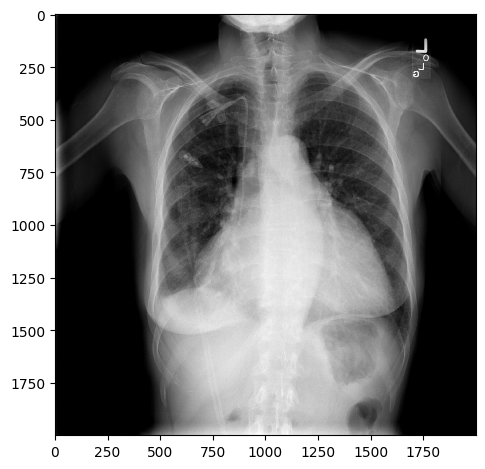

Atelectasis Classification



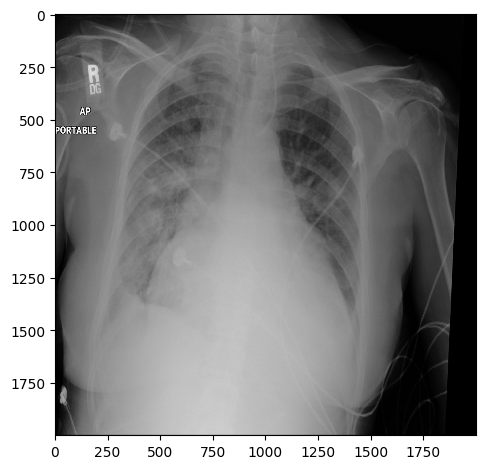

Cardiomegaly Classification



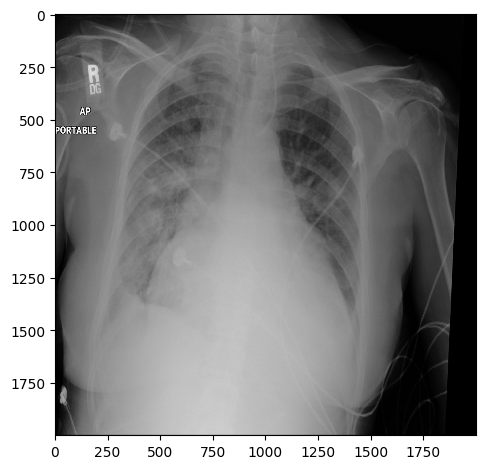

Infiltrate Classification



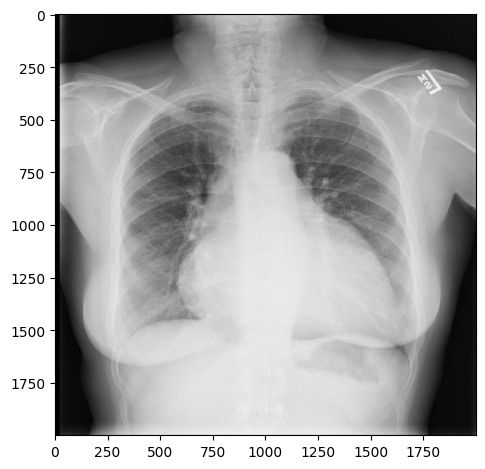

No Finding Classification


In [ ]:
# # looking at some of the images that are from the same patient, yet list multiple labels
from skimage import io, transform

def show_resized_img(img_path, new_height, new_width):
    img = io.imread(img_path)
    resized_img = transform.resize(img, (new_height, new_width))
    io.imshow(resized_img)
    io.show()

print("From Patient 211:")

img_path = "/content/medical-ai/images/00000211_010.jpg"
#showImg(img_path)
show_resized_img(img_path, 2000, 2000)
print("Atelectasis Classification")
print()

img_path = "/content/medical-ai/images/00000211_041.jpg"
# showImg(img_path)
show_resized_img(img_path, 2000, 2000)
print("Cardiomegaly Classification")
print()

img_path = "/content/medical-ai/images/00000211_041.jpg"
#showImg(img_path)
show_resized_img(img_path, 2000, 2000)
print("Infiltrate Classification")
print()

img_path = "/content/medical-ai/images/00000211_003.jpg"
#showImg(img_path)
show_resized_img(img_path, 2000, 2000)
print("No Finding Classification")

From Patient 468:


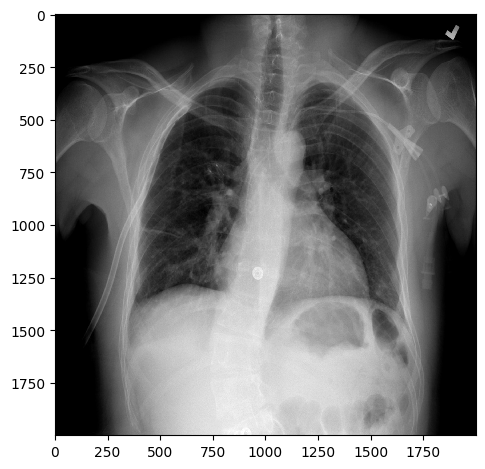

Atelectasis Classification



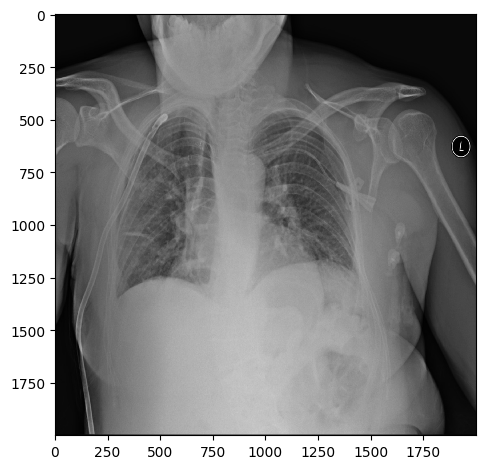

Atelectasis Classification 2



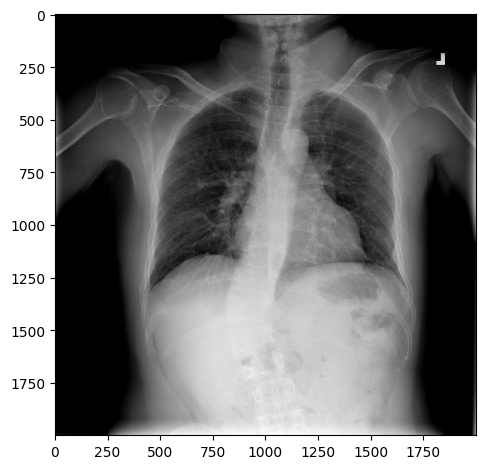

Infiltrate Classification



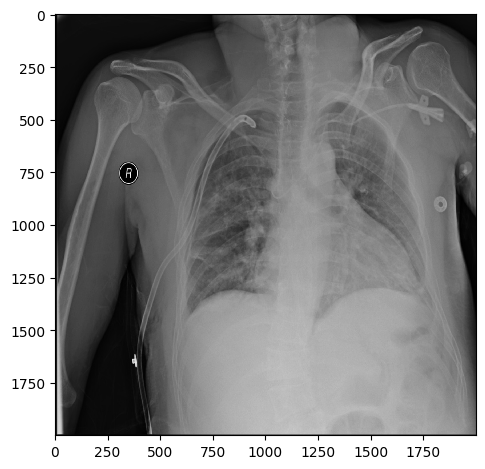

No Finding Classification



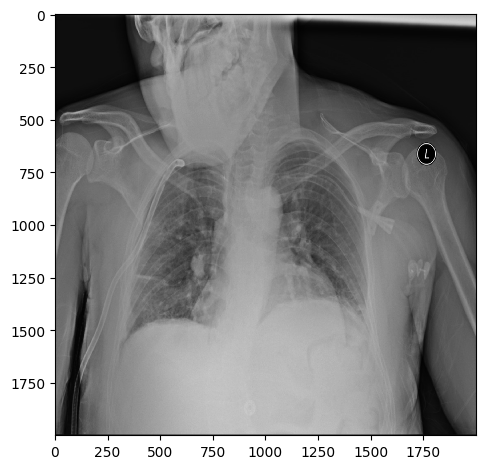

No Finding Classification 2


In [ ]:
print("From Patient 468:")

img_path = "/content/medical-ai/images/00000468_033.jpg"
show_resized_img(img_path, 2000, 2000)
print("Atelectasis Classification")
print()
img_path = "/content/medical-ai/images/00000468_017.jpg"
show_resized_img(img_path, 2000, 2000)
print("Atelectasis Classification 2")
print()
img_path = "/content/medical-ai/images/00000468_041.jpg"
show_resized_img(img_path, 2000, 2000)
print("Infiltrate Classification")
print()
img_path = "/content/medical-ai/images/00000468_015.jpg"
show_resized_img(img_path, 2000, 2000)
print("No Finding Classification")
print()
img_path = "/content/medical-ai/images/00000468_021.jpg"
show_resized_img(img_path, 2000, 2000)
print("No Finding Classification 2")

# <font color= 'blue'> Modified Goal
Goal was modified as a result of the analysis and further research about the dataset


<font color= 'blue'> New goal: *Use a convolutional neural network to classify Chest X-Rays into 1 of 2 classes of X-Ray views (anteriorposterior, posterioranterior)*

## Reason for Goal Modification:
Looking at these disease classifications, some of them seem incorrect. For example, although there are multiple chest x ray images of Patient 211 and seems to definitely have cardiomegaly, there is an instance where the CXR is mislabeled with "no finding". The labeling seems to be much more flawed than reported by the dataset authors. **Upon further research, it seems that other researchers/experts in the field are also in agreement with the fact that this dataset is not reliable (Oakden-Rayner, 2017) and the conclusion that mislabeling is a point of concern (Nguygen et. al, 2022).** Based on the provided information about the dataset as well, it seems that no portion of images were directly annotated or cross-checked by radiologists. The labels for diseases were text-mined, and while accuracy reported to be high, it seems there is some disconnect between the reported and true values.

Because of this unreliability within the labeling of the dataset, **I decided to focus on classifying the view that the image was taken from (anteriorposterior (AP) or posterioranterior (PA)**, which is a reliable point information that was not text-mined in this dataset. Some diseases can be better identified/detected by looking at a different view (AP vs. PA), so this classifying the point of view may also be relevant information in future models that will later classify the disease itself as well. It could aid in creating other datasets as well.

**References:**

Nguygen, H., Lam, K., Le, L., Pham, H., Train, D., Nguyen, D., Le, D., Pham, C., Tong, H., Dinh, D., Do, C., Doan, L., Nguyen, C., Nguyen, B., Nguygen, Q., Hoang, A., Ho, P., Ngo, D., Nguyen, N., Nguyen, N., Dao, M., Vu, V. (2022). VinDr-CXR: An open dataset of chest X-rays with radiologist’s annotations. *Sci Data, 9*(1):429. doi: [10.1038/s41597-022-01498-w.](https://www.nature.com/articles/s41597-022-01498-w)

Oakden-Rayner. (2017). Exploring the ChestXray14 dataset: problems. Retrieved from https://laurenoakdenrayner.com/2017/12/18/the-chestxray14-dataset-problems/


# <font color= 'blue'> Dataset Preprocressing & Preparation for Modified Goal
Created new directories, removed duplicates, made new data splits, re-labeled images with new target labels:

Note: *Dataset size reduced from 1,984 to 1,100 after removing duplicates*

- deleted duplicates from image folder from csv (using dataframe made earlier in project for original goal from section "Preventing Data Leakage")
- used csv to label all images with "view" class
- used csv to split images into train & test (80%, 20%) by filename
- loaded images into respective train/test directions & classes directories

## Removing duplicates


In [ ]:
count = (df_unique_random['view'] == 'AP').sum()
print("Number of images/CXRs with AP view: ", count)
count = (df_unique_random['view'] == 'PA').sum()
print("Number of images/CXRs with PA view: ", count)

Number of images/CXRs with AP view:  361
Number of images/CXRs with PA view:  739


In [ ]:
# code in progress
import os

input_folder = "/content/medical-ai/images"
# "/content/medical-ai/images"
# delete all duplicates

total_count = 0

for filename in os.listdir(input_folder):
  if filename not in df_unique_random['filename'].values: #. values returns a numpy array of the column

    # construct full image path to file
    image_path = os.path.join(input_folder, filename)

    # Check if the image file exists before attempting to delete
    if os.path.exists(image_path):

      # Delete the image file
      os.remove(image_path)
      total_count += 1

    else:
      print("Image not found:", image_path)

## Making data splits
- create directories optimized for dataloader object organization:




    content
      medical-ai
        images
          train
            AP
            PA
          test
            AP
            PA
          val
            AP
            PA

In [ ]:
# Read the CSV file into a DataFrame
data = pd.read_csv('labels_reduced.csv')

# Shuffle the data
shuffled_data = data.sample(frac=1, random_state=100)  # random_state for reproducibility

# Split the data into training 80 percent (60% of all) and testing 20 percent (40% of all) sets
train_df, test_df = train_test_split(shuffled_data, test_size=0.4, shuffle=True, random_state=42)

# Split the data into valid 50 percent (20% of all) and test 50 percent (20% of all)
val_df, test_df = train_test_split(test_df, test_size=0.5, shuffle=True, random_state=100)

# Write to new CSV files --> just in case (can store csv for future sessions or just re-run code)
train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

# split the csv into 0.8 (train) and 0.2 (test)
# split train into AP and PA
# split test into AP and PA
# map all filenames assocated with train AP & PA to the actual filename for the images and then put them in the correct folder
# do the same for test AP & PA

# dont worry about shuffling, dataloader will do it itself

In [ ]:
print("Train: ")
count = (train_df['view'] == 'AP').sum()
print(" AP view: ", count)
count = (train_df['view'] == 'PA').sum()
print(" PA view: ", count)
print("Val: ")
count = (val_df['view'] == 'AP').sum()
print(" AP view: ", count)
count = (val_df['view'] == 'PA').sum()
print(" PA view: ", count)
print("Test: ")
count = (test_df['view'] == 'AP').sum()
print(" AP view: ", count)
count = (test_df['view'] == 'PA').sum()
print(" PA view: ", count)

Train: 
 AP view:  220
 PA view:  440
Val: 
 AP view:  76
 PA view:  144
Test: 
 AP view:  65
 PA view:  155


In [ ]:
index_soft = train_df.index[train_df['filename'] == '00016487_002.jpg']
print("index_soft: ", str(index_soft[0]))
index = 3
print(train_df.loc[3, 'view'])
print(train_df.loc[index_soft[0], 'view'])
class_label = train_df.loc[index_soft, 'view'] # AP or PA
print("class_label: ", class_label)

index_soft:  370
AP
PA
class_label:  370    PA
Name: view, dtype: object


In [ ]:
# create directories
rootdir = "/content/medical-ai/images"
os.makedirs(rootdir+"/test/AP",  exist_ok=True)
os.makedirs(rootdir+"/test/PA",  exist_ok=True)
os.makedirs(rootdir+"/val/AP",  exist_ok=True)
os.makedirs(rootdir+"/val/PA",  exist_ok=True)
os.makedirs(rootdir+"/train/AP", exist_ok=True)
os.makedirs(rootdir+"/train/PA", exist_ok=True)

In [ ]:
# code in progress
import os
import shutil

input_folder = "/content/medical-ai/images"
new_folder = "/content/medical-ai/images"
# "/content/medical-ai/images"
# delete all duplicates

total_count = 0

for filename in os.listdir(input_folder):
  print("Filename: ", filename)

  # construct full image path to file
  image_path = os.path.join(input_folder, filename)

  # Check if the image file exists before anything
  if os.path.exists(image_path):
    # check if filename in train df
    if filename in (train_df['filename'].values):
      new_folder_split = "/content/medical-ai/images"+"/train"
      index = train_df.index[train_df['filename'] == filename]

      # index is an object: Index([index_int], )
      # have to change index to int for accessing to work correctly
      index_int = index[0]

      class_label = train_df.loc[index_int, 'view'] # AP or PA
      print("class_label: ", class_label)

      #new_image_path = os.path.join(new_folder_split, class_label)
      new_image_path = os.path.join(new_folder_split, class_label, filename)
      #os.rename(image_path, new_image_path)
      #os.replace(image_path, new_image_path)
      shutil.move(image_path, new_image_path)

    elif filename in (val_df['filename'].values):
      # make sure filename is in test_df
      if filename in (val_df['filename'].values):
        new_folder_split = "/content/medical-ai/images"+"/val"
        index = val_df.index[val_df['filename'] == filename]

        # index is an object: Index([index_int], )
        # have to change index to int for accessing to work correctly
        index_int = index[0]

        class_label = val_df.loc[index_int, 'view'] # AP or PA
        #new_image_path = os.path.join(new_folder_split, class_label)
        new_image_path = os.path.join(new_folder_split, class_label, filename)
        #os.rename(image_path, new_image_path)
        #os.replace(image_path, new_image_path)
        shutil.move(image_path, new_image_path)
      else:
        print("Image not in train_df or test_df")

    else:

      # make sure filename is in test_df
      if filename in (test_df['filename'].values):
        new_folder_split = "/content/medical-ai/images"+"/test"
        index = test_df.index[test_df['filename'] == filename]

        # index is an object: Index([index_int], )
        # have to change index to int for accessing to work correctly
        index_int = index[0]

        class_label = test_df.loc[index_int, 'view'] # AP or PA
        #new_image_path = os.path.join(new_folder_split, class_label)
        new_image_path = os.path.join(new_folder_split, class_label, filename)
        #os.rename(image_path, new_image_path)
        #os.replace(image_path, new_image_path)
        shutil.move(image_path, new_image_path)
      else:
        print("Image not in train_df or test_df or val_df") # if image not in train/val/test_df, filename might be a directory or something other than image (ex: test folder)

  else:
    print("Image does not exist!")

Filename:  00027556_007.jpg
Filename:  00030634_000.jpg
Filename:  00000430_002.jpg
class_label:  PA
Filename:  00016291_020.jpg
Filename:  00010805_049.jpg
class_label:  AP
Filename:  00019058_004.jpg
class_label:  AP
Filename:  00000082_000.jpg
class_label:  PA
Filename:  00000199_003.jpg
Filename:  00013992_005.jpg
class_label:  AP
Filename:  00022572_005.jpg
Filename:  00012686_003.jpg
Filename:  00021181_002.jpg
class_label:  PA
Filename:  00011514_015.jpg
class_label:  AP
Filename:  00000371_000.jpg
Filename:  00000360_002.jpg
Filename:  00000137_001.jpg
Filename:  00015064_001.jpg
class_label:  AP
Filename:  00000322_012.jpg
class_label:  PA
Filename:  00020000_000.jpg
class_label:  PA
Filename:  00000410_000.jpg
class_label:  PA
Filename:  00015799_012.jpg
class_label:  AP
Filename:  00000174_004.jpg
Filename:  00000283_000.jpg
class_label:  PA
Filename:  00019765_010.jpg
Filename:  00027837_001.jpg
class_label:  AP
Filename:  00020564_000.jpg
Filename:  00000150_002.jpg
class_

## <font color= 'blue'> Model Functions

### Function: resize_batches
- allows to specify resizing for images and images per batch size for dataloader/dataset
- includes image transformations to grayscale

In [ ]:

# THIS IS A FUNCTION FOR RESIZING AND CREATING BATCHES FOR THE DATA
# DECIDED NOT TO REQUIRE H FOR THE FUNCTION
def resize_batches(resize_dim, u_batch_size):

  # Set up the data directory
  data_dir = "/content/medical-ai/images"

  # have to setup the transforms first (resize and convert to grayscale)
  data_transforms = transforms.Compose([
      transforms.Resize(size=(resize_dim, resize_dim)),
      transforms.Grayscale(),  # Convert to grayscale
      transforms.ToTensor(),
  ])


  # Load the datasets  --> note: THIS DOES NOT ALTER THE ORIGINAL DATA
  train_dataset = datasets.ImageFolder(data_dir+"/train", transform=data_transforms)
  valid_dataset = datasets.ImageFolder(data_dir+"/val", transform=data_transforms)
  test_dataset = datasets.ImageFolder(data_dir+"/test", transform=data_transforms)


  # Create the data loaders
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= u_batch_size, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size= u_batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= u_batch_size, shuffle=True)


  # print to make sure
  print("Training Dataset")
  total_batches = len(train_loader); total_samples = len(train_loader.dataset)
  print("Total batches:", total_batches); print("Total samples:", total_samples)
  print("Images per batch:", u_batch_size)
  print()


  print("Validation Dataset")
  total_batches = len(valid_loader); total_samples = len(valid_loader.dataset)
  print("Total samples:", total_samples)
  print()


  print("Testing Dataset")
  total_batches = len(test_loader); total_samples = len(test_loader.dataset)
  print("Total samples:", total_samples)
  print()

  return train_loader, train_dataset, valid_loader, valid_dataset, test_loader, test_dataset

# example usage:
# train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(256, 64)


### Function: training
- utilizes GPU
- uses dataloader and dataset output from previous function

This MUST be run done before training function and performance function when used in later code:
```
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}") # making sure gpu is being used

# initalize model
model = model.to(device)
```

In [ ]:
import torch
import time

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Device: {device}") # making sure gpu is being used

def training(model, train_loader, val_loader, optimizer, criterion, epochs, device):

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
      start_time = time.time()
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0

      for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # for using GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

      train_loss = running_loss / len(train_loader)
      train_accuracy = correct_train / total_train
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

      end_time = time.time()

      print(f"Epoch [{epoch + 1}/{epochs}], "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, "
            f"Time: {end_time - start_time:.2f} sec")

    # Plot the learning curve
    plt.plot(train_losses, 'orange', label='Train Loss')
    plt.plot(val_losses, 'blue', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss history')
    plt.legend()
    plt.show()

def evaluate(model, loader, criterion, device):
    model.eval()

    total_samples = len(loader.dataset)
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
      for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device) # for using GPU

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    loss = running_loss / len(loader)
    accuracy = correct / total_samples
    return loss, accuracy


### Function: get_performance
- utilizes GPU
- prints predicted labels, classification report, confusion matrix, p/c/acc

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def get_performance(model, data_loader, data_dataset, string, device):

  # Initialize empty lists to store true labels and predictions
  true_labels = []
  predicted_labels = []
  correct = 0

  # Accumulate true labels and predictions for all mini-batches in the data set
  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = images.to(device), labels.to(device) # using gpu
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      true_labels.extend(labels.cpu().numpy()) # using cpu to convert to numpy!!
      predicted_labels.extend(predicted.cpu().numpy()) # using cpu to convert to numpy!!
      correct += (predicted == labels).sum().item()


  print("Accuracy on the", string, f"set: {correct / len(data_dataset):.2%}")
  print("Number of predictions: ", len(data_dataset))

  # Calculate precision, recall, and F1 score using the accumulated true labels and predictions
  precision = precision_score(true_labels, predicted_labels)
  recall = recall_score(true_labels, predicted_labels)
  f1 = f1_score(true_labels, predicted_labels)

  print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")

  # Print out Classification Report using the accumulated true labels and predictions
  print("Classification Report for ", string, " Dataset")
  print(classification_report(true_labels, predicted_labels, labels=[0, 1]))

  # Calculate the Confusion Matrix
  cm = confusion_matrix(true_labels, predicted_labels)

  print("Predicted lables: ", predicted_labels)

  # Visualize the confusion matrix + Set Title!!
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["AP", "PA"])
  disp.plot()
  disp.ax_.set_title(str(string) + " Dataset Confusion Matrix")

# <font color= 'blue'> Benchmark Model
## runtime: 1 min
> train macro accuracy: 40% ------ val macro accuracy: 39%

*Description:* Flattened images, then used two sigmoid activated neurons for output.
- 1 batch
- adam optimizer
- 100 image esize
adam optimizer.

idea/note to self: in our eyes, there are "on-cell" and "off-cell"s and they allow our eyes to understand/identify contrasts. maybe could add something like that in the future / research more about it

*Results:* Stuck on 1 value for predictions, so only 1 class was predicted

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

model = torch.nn.Sequential(
  torch.nn.Flatten(),
  torch.nn.Linear(1 * 100 * 100, 2),
  # 1 --> number of channels (1 for grayscale, 3 for RGB)
  # 56 * 56 --> pixel x pixel size of images [in_features]
  # 512 --> number of neurons in fully connected layer (output of flatten layer) [out_features]
  torch.nn.Sigmoid()

  # 512 --> [in_features]
  # 2 --> number of classes for classification problem [out_features]
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
# train_loader, train_dataset, valid_loader, valid_dataset, test_loader, test_dataset = resize_batches(100, 660)
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(100, 660)

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

1.weight cuda:0
1.bias cuda:0

Training Dataset
Total batches: 1
Total samples: 660
Images per batch: 660

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  226
Number of 1s (PA):  434
Validation
Number of 0s (AP):  80
Number of 1s (PA):  140


Epoch [1/10], Train Loss: 0.6839, Train Acc: 0.6500, Val Loss: 0.6748, Val Acc: 0.6364, Time: 13.46 sec
Epoch [2/10], Train Loss: 0.6537, Train Acc: 0.6576, Val Loss: 0.6768, Val Acc: 0.6364, Time: 8.83 sec
Epoch [3/10], Train Loss: 0.6555, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 8.06 sec
Epoch [4/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 8.86 sec
Epoch [5/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 8.80 sec
Epoch [6/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 7.94 sec
Epoch [7/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 8.86 sec
Epoch [8/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 8.86 sec
Epoch [9/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 9.21 sec
Epoch [10/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, 

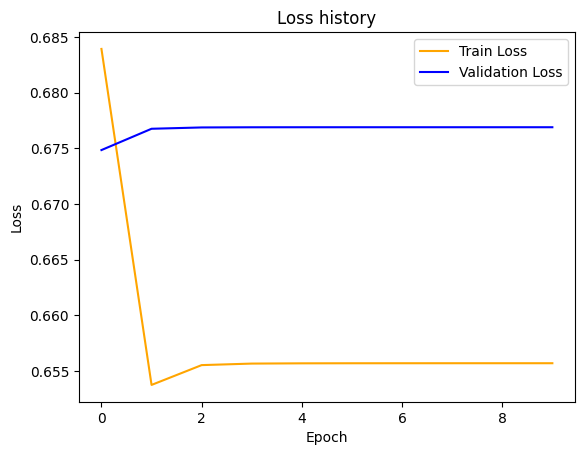

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Benchmark Training/Results Notes: ...

Accuracy on the Training set: 65.76%
Number of predictions:  660
Precision: 0.66, Recall: 1.00, F1 score: 0.79
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       226
           1       0.66      1.00      0.79       434

    accuracy                           0.66       660
   macro avg       0.33      0.50      0.40       660
weighted avg       0.43      0.66      0.52       660

Predicted lables:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


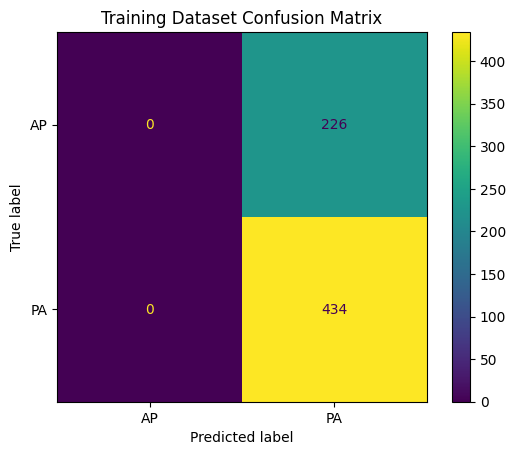

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 63.64%
Number of predictions:  220
Precision: 0.64, Recall: 1.00, F1 score: 0.78
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.64      1.00      0.78       140

    accuracy                           0.64       220
   macro avg       0.32      0.50      0.39       220
weighted avg       0.40      0.64      0.49       220

Predicted lables:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


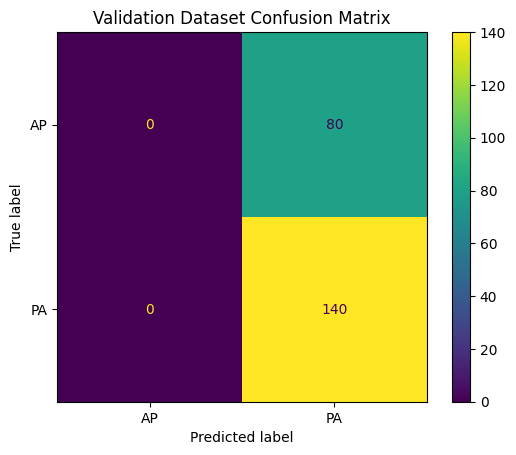

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

Confusion Matrix notes:

Classifying AP as PA, (false negatives) = Lower Recall.
Accuracy on AP is 0%
need to use macro average from classification report to analyze next models







Confusion Matrix & precision/recall
```
{'tn': [0, 0],'fp': [0, 1]}
{'fn': [1, 0],'tp': [1, 1]}
```

*   precision = true positives / true positives + false positives
*   recall = true positives / true positives + false negatives

`the closer precision is to 1, the less false positives there are.`

`the closer recall is to 1, the less false negatives there are.`

Predictions are all interpreted as 1. Model predictions might be averaging at some constant, increasing batch size  might help

# <font color= 'blue'> Experiment 1: Fully Connected Model - Batch Size (660, 330, 200, 80)
660 batch size (1 batch - from previous benchmark model), 330 batch size , 200 batch size, 100 batch size, 80 batch size
- kept benchmark model with additional fully connected layer as constant throughout entire experiment
- tested different batch sizes

*Description:* Flattened images, then used 2 fully connected layers (relu, 512 neurons) (sigmoid, 2 output neurons)
- adam optimizer
- 100 image resize

*Results:* Stuck on 1 value for predictions, so only 1 class was predicted for all models of varying batch sizes

*Best Model:* Inconclusive, since all models were stuck on 1 value. Convolutional neural network may help improve performance and encourage learning. (Re-tested batch size in future experiment)


## 660 batch size
### train macro accuracy = 40%; val macro accuracy = 39%

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# Create the model and optimizer
model = torch.nn.Sequential(
  torch.nn.Flatten(),
  torch.nn.Linear(1 * 100 * 100, 512),
  # 1 --> number of channels (1 for grayscale, 3 for RGB)
  # 56 * 56 --> pixel x pixel size of images [in_features]
  # 512 --> number of neurons in fully connected layer (output of flatten layer) [out_features]
  torch.nn.ReLU(),
  torch.nn.Linear(512, 2),
  # 512 --> [in_features]
  # 2 --> number of classes for classification problem [out_features]
  torch.nn.Sigmoid()
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(100, 660)

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

1.weight cuda:0
1.bias cuda:0
3.weight cuda:0
3.bias cuda:0

Training Dataset
Total batches: 1
Total samples: 660
Images per batch: 660

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  226
Number of 1s (PA):  434
Validation
Number of 0s (AP):  80
Number of 1s (PA):  140


Epoch [1/10], Train Loss: 0.7103, Train Acc: 0.3424, Val Loss: 0.6769, Val Acc: 0.6364, Time: 15.47 sec
Epoch [2/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 9.85 sec
Epoch [3/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 13.47 sec
Epoch [4/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 11.64 sec
Epoch [5/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 8.84 sec
Epoch [6/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 8.79 sec
Epoch [7/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 8.13 sec
Epoch [8/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 9.16 sec
Epoch [9/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 9.05 sec
Epoch [10/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769

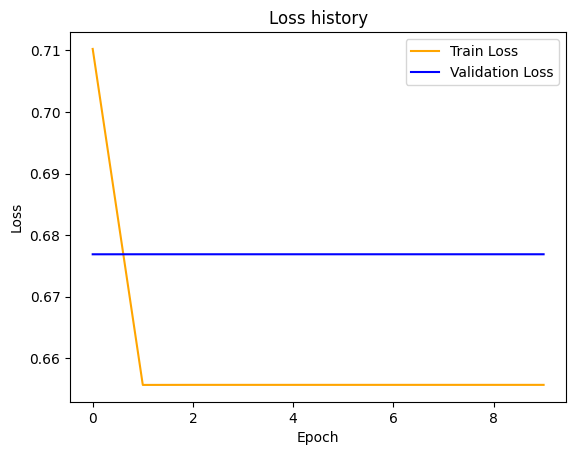

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Accuracy on the Training set: 65.76%
Number of predictions:  660
Precision: 0.66, Recall: 1.00, F1 score: 0.79
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       226
           1       0.66      1.00      0.79       434

    accuracy                           0.66       660
   macro avg       0.33      0.50      0.40       660
weighted avg       0.43      0.66      0.52       660

Predicted lables:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


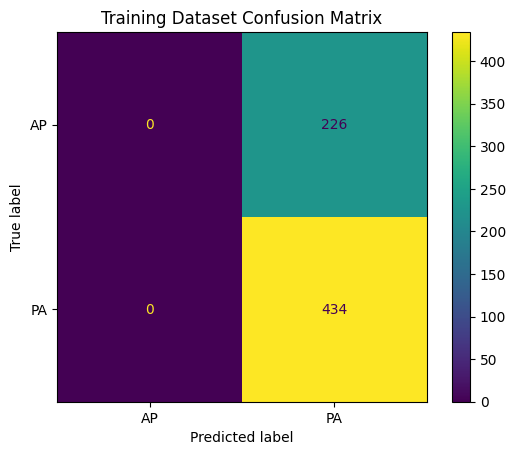

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 63.64%
Number of predictions:  220
Precision: 0.64, Recall: 1.00, F1 score: 0.78
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.64      1.00      0.78       140

    accuracy                           0.64       220
   macro avg       0.32      0.50      0.39       220
weighted avg       0.40      0.64      0.49       220

Predicted lables:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


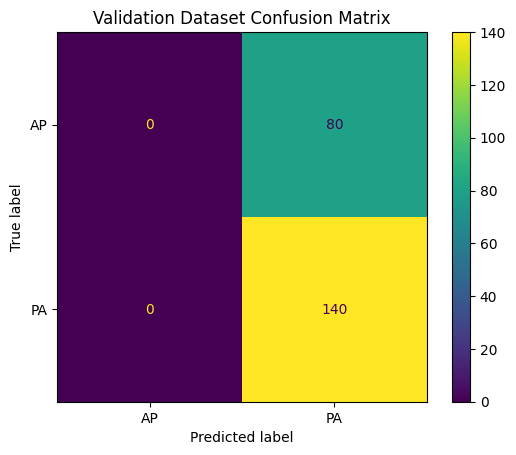

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

## 330 batch size
### train macro accuracy = 40%; val macro accuracy = 39%

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# Create the model and optimizer
model = torch.nn.Sequential(
  torch.nn.Flatten(),
  torch.nn.Linear(1 * 100 * 100, 512),
  # 1 --> number of channels (1 for grayscale, 3 for RGB)
  # 56 * 56 --> pixel x pixel size of images [in_features]
  # 512 --> number of neurons in fully connected layer (output of flatten layer) [out_features]
  torch.nn.ReLU(),
  torch.nn.Linear(512, 2),
  # 512 --> [in_features]
  # 2 --> number of classes for classification problem [out_features]
  torch.nn.Sigmoid()
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(100, 330)

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

1.weight cuda:0
1.bias cuda:0
3.weight cuda:0
3.bias cuda:0

Training Dataset
Total batches: 2
Total samples: 660
Images per batch: 330

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  226
Number of 1s (PA):  434
Validation
Number of 0s (AP):  80
Number of 1s (PA):  140


Epoch [1/10], Train Loss: 0.6636, Train Acc: 0.6197, Val Loss: 0.6769, Val Acc: 0.6364, Time: 13.96 sec
Epoch [2/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 9.43 sec
Epoch [3/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 7.98 sec
Epoch [4/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 8.88 sec
Epoch [5/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 8.86 sec
Epoch [6/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 8.64 sec
Epoch [7/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 8.17 sec
Epoch [8/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 9.20 sec
Epoch [9/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769, Val Acc: 0.6364, Time: 11.78 sec
Epoch [10/10], Train Loss: 0.6557, Train Acc: 0.6576, Val Loss: 0.6769,

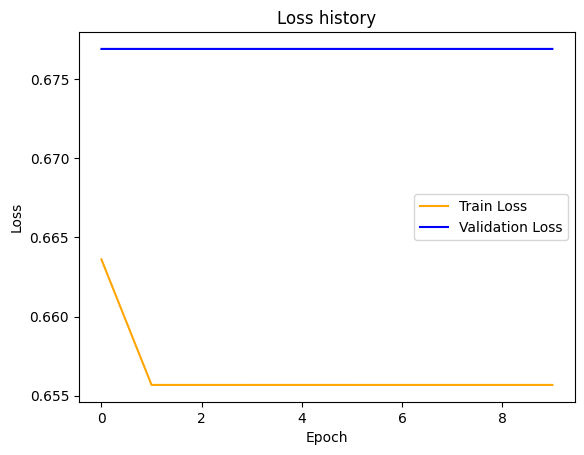

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Benchmark Training/Results Notes: ...

Accuracy on the Training set: 65.76%
Number of predictions:  660
Precision: 0.66, Recall: 1.00, F1 score: 0.79
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       226
           1       0.66      1.00      0.79       434

    accuracy                           0.66       660
   macro avg       0.33      0.50      0.40       660
weighted avg       0.43      0.66      0.52       660

Predicted lables:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


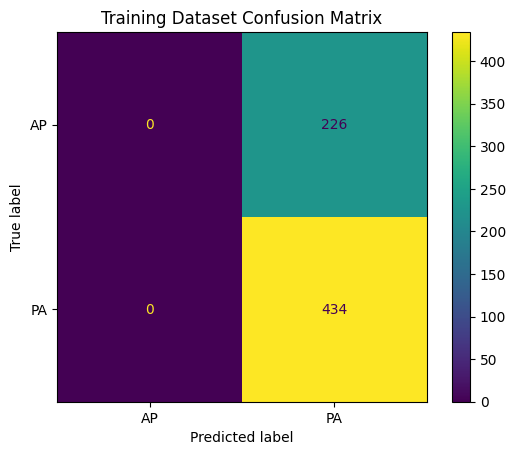

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 63.64%
Number of predictions:  220
Precision: 0.64, Recall: 1.00, F1 score: 0.78
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.64      1.00      0.78       140

    accuracy                           0.64       220
   macro avg       0.32      0.50      0.39       220
weighted avg       0.40      0.64      0.49       220

Predicted lables:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


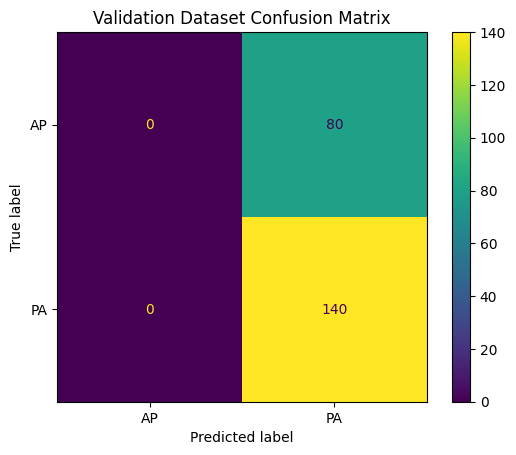

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

## 200 batch size
### train macro accuracy = 40%; val macro accuracy = 39%

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# Create the model and optimizer
model = torch.nn.Sequential(
  torch.nn.Flatten(),
  torch.nn.Linear(1 * 100 * 100, 512),
  # 1 --> number of channels (1 for grayscale, 3 for RGB)
  # 56 * 56 --> pixel x pixel size of images [in_features]
  # 512 --> number of neurons in fully connected layer (output of flatten layer) [out_features]
  torch.nn.ReLU(),
  torch.nn.Linear(512, 2),
  # 512 --> [in_features]
  # 2 --> number of classes for classification problem [out_features]
  torch.nn.Sigmoid()
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(100, 200)

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

1.weight cuda:0
1.bias cuda:0
3.weight cuda:0
3.bias cuda:0

Training Dataset
Total batches: 4
Total samples: 660
Images per batch: 200

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  226
Number of 1s (PA):  434
Validation
Number of 0s (AP):  80
Number of 1s (PA):  140


Epoch [1/10], Train Loss: 0.6682, Train Acc: 0.5667, Val Loss: 0.7383, Val Acc: 0.6364, Time: 16.93 sec
Epoch [2/10], Train Loss: 0.6599, Train Acc: 0.6576, Val Loss: 0.6708, Val Acc: 0.6364, Time: 10.17 sec
Epoch [3/10], Train Loss: 0.6424, Train Acc: 0.6576, Val Loss: 0.6483, Val Acc: 0.6364, Time: 8.75 sec
Epoch [4/10], Train Loss: 0.6483, Train Acc: 0.6576, Val Loss: 0.7383, Val Acc: 0.6364, Time: 8.09 sec
Epoch [5/10], Train Loss: 0.6658, Train Acc: 0.6576, Val Loss: 0.6933, Val Acc: 0.6364, Time: 8.83 sec
Epoch [6/10], Train Loss: 0.6599, Train Acc: 0.6576, Val Loss: 0.6933, Val Acc: 0.6364, Time: 8.81 sec
Epoch [7/10], Train Loss: 0.6541, Train Acc: 0.6576, Val Loss: 0.6483, Val Acc: 0.6364, Time: 7.99 sec
Epoch [8/10], Train Loss: 0.6395, Train Acc: 0.6576, Val Loss: 0.6258, Val Acc: 0.6364, Time: 9.24 sec
Epoch [9/10], Train Loss: 0.6687, Train Acc: 0.6576, Val Loss: 0.7383, Val Acc: 0.6364, Time: 8.85 sec
Epoch [10/10], Train Loss: 0.6570, Train Acc: 0.6576, Val Loss: 0.7158,

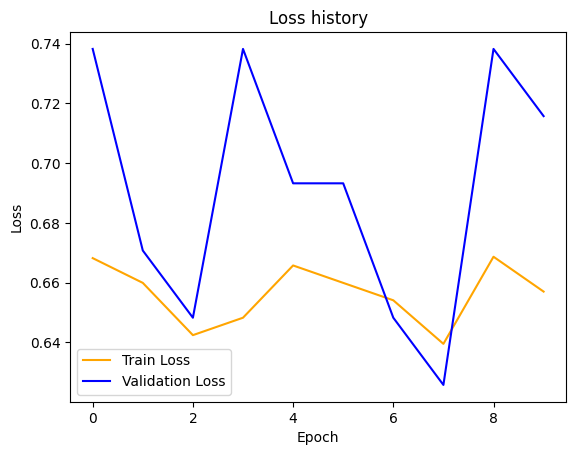

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Benchmark Training/Results Notes: ...

Accuracy on the Training set: 65.76%
Number of predictions:  660
Precision: 0.66, Recall: 1.00, F1 score: 0.79
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       226
           1       0.66      1.00      0.79       434

    accuracy                           0.66       660
   macro avg       0.33      0.50      0.40       660
weighted avg       0.43      0.66      0.52       660

Predicted lables:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


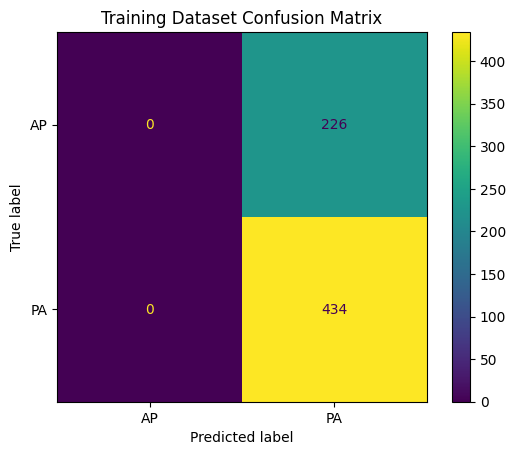

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 63.64%
Number of predictions:  220
Precision: 0.64, Recall: 1.00, F1 score: 0.78
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.64      1.00      0.78       140

    accuracy                           0.64       220
   macro avg       0.32      0.50      0.39       220
weighted avg       0.40      0.64      0.49       220

Predicted lables:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


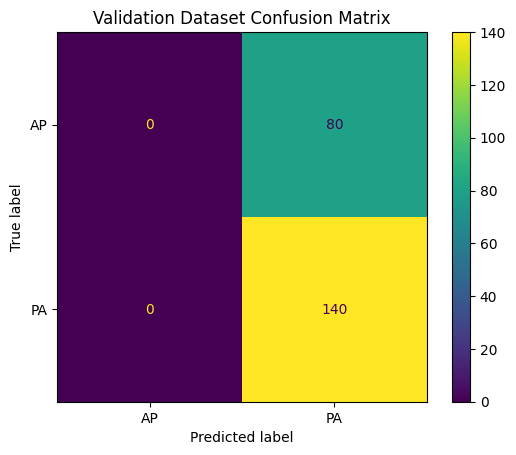

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

## 80 batch size
### train macro accuracy = 40%; val macro accuracy = 39%


In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# Create the model and optimizer
model = torch.nn.Sequential(
  torch.nn.Flatten(),
  torch.nn.Linear(1 * 100 * 100, 512),
  # 1 --> number of channels (1 for grayscale, 3 for RGB)
  # 56 * 56 --> pixel x pixel size of images [in_features]
  # 512 --> number of neurons in fully connected layer (output of flatten layer) [out_features]
  torch.nn.ReLU(),
  torch.nn.Linear(512, 2),
  # 512 --> [in_features]
  # 2 --> number of classes for classification problem [out_features]
  torch.nn.Sigmoid()
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
  print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(100, 80)

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

1.weight cuda:0
1.bias cuda:0
3.weight cuda:0
3.bias cuda:0

Training Dataset
Total batches: 9
Total samples: 660
Images per batch: 80

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  226
Number of 1s (PA):  434
Validation
Number of 0s (AP):  80
Number of 1s (PA):  140


Epoch [1/10], Train Loss: 0.6737, Train Acc: 0.6576, Val Loss: 0.6772, Val Acc: 0.6364, Time: 15.02 sec
Epoch [2/10], Train Loss: 0.6647, Train Acc: 0.6576, Val Loss: 0.6869, Val Acc: 0.6364, Time: 8.45 sec
Epoch [3/10], Train Loss: 0.6605, Train Acc: 0.6576, Val Loss: 0.6785, Val Acc: 0.6364, Time: 8.96 sec
Epoch [4/10], Train Loss: 0.6730, Train Acc: 0.6576, Val Loss: 0.6702, Val Acc: 0.6364, Time: 9.78 sec
Epoch [5/10], Train Loss: 0.6480, Train Acc: 0.6576, Val Loss: 0.6758, Val Acc: 0.6364, Time: 8.93 sec
Epoch [6/10], Train Loss: 0.6647, Train Acc: 0.6576, Val Loss: 0.6758, Val Acc: 0.6364, Time: 10.12 sec
Epoch [7/10], Train Loss: 0.6688, Train Acc: 0.6576, Val Loss: 0.6799, Val Acc: 0.6364, Time: 9.57 sec
Epoch [8/10], Train Loss: 0.6563, Train Acc: 0.6576, Val Loss: 0.6758, Val Acc: 0.6364, Time: 8.90 sec
Epoch [9/10], Train Loss: 0.6522, Train Acc: 0.6576, Val Loss: 0.6799, Val Acc: 0.6364, Time: 8.95 sec
Epoch [10/10], Train Loss: 0.6480, Train Acc: 0.6576, Val Loss: 0.6744,

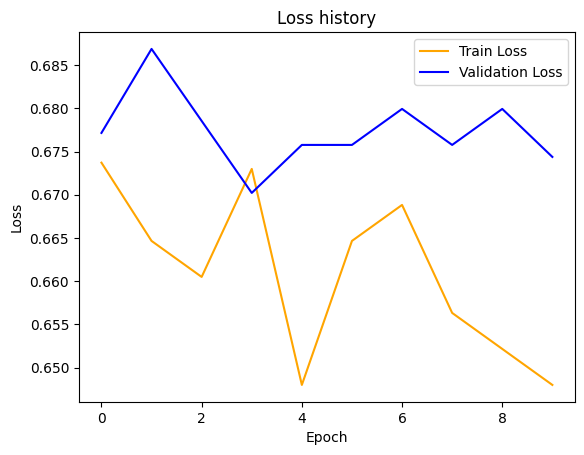

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Benchmark Training/Results Notes: ...

Accuracy on the Training set: 65.76%
Number of predictions:  660
Precision: 0.66, Recall: 1.00, F1 score: 0.79
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       226
           1       0.66      1.00      0.79       434

    accuracy                           0.66       660
   macro avg       0.33      0.50      0.40       660
weighted avg       0.43      0.66      0.52       660

Predicted lables:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


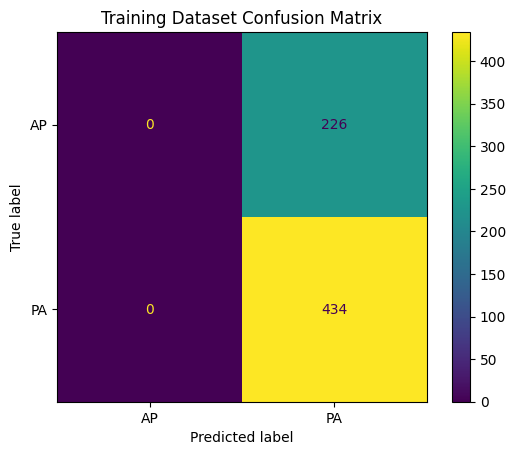

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 63.64%
Number of predictions:  220
Precision: 0.64, Recall: 1.00, F1 score: 0.78
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.64      1.00      0.78       140

    accuracy                           0.64       220
   macro avg       0.32      0.50      0.39       220
weighted avg       0.40      0.64      0.49       220

Predicted lables:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


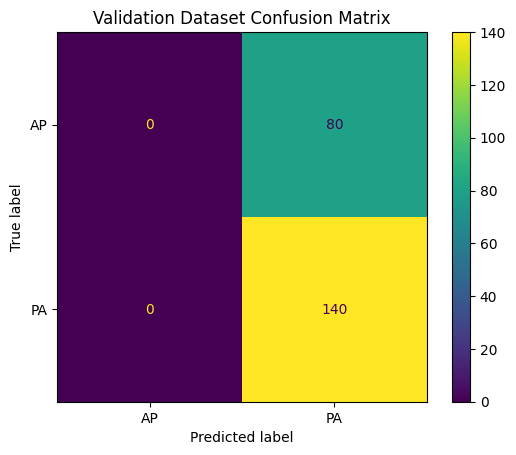

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

# <font color= 'blue'> Experiment 2: Number of Convolutional Layers (1, 2, 3)
Added convolutional layers to 2 fully connected model network

*Description:* Used convolutional layers with same padding, 1 stride, and 2x2 max pooling. Number of kernels was halfed for each additional convolutional layer. 16 neurons for first convolutional layer kept as constant.
- adam optimizer
- 100 image resize
- 200 batch size


*Results:* Predictions finally were no longer stuck on an average/constant value, model started learning training dataset for 2 convolutional layers. Model became stuck on one value again for 3 convolutional layers.

*Best Model:* 2 convolutional layers

## 2 convolutional layers
### train macro accuracy = 80%; val macro accuracy = 80%

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# model hyperparameters
h = {
    "num_epochs": 10,
    "batch_size": 200,
    "image_size": 100,
    "fc1_size": 512,
    "lr": 0.001
}

# Create the model and optimizer
model = nn.Sequential(
  nn.Conv2d(1, 16, 3, stride = 1, padding = 1),
  # (input channels, output channels, filter size, stride, padding)
  # padding = 1 is similar to "padding=same" in keras
  # input channels --> number image color channels [grayscale: 1; rgb: 3]
  # output channels --> number of filters/kernels --> meaning number of neurons
  nn.ReLU(),
  # conv2D activation
  nn.MaxPool2d(2, 2),
  # image output shape reduced by factor of 2:  ex. before --> 1x56x56, after --> 1x28x28

  nn.Conv2d(16, 8, 3, stride = 1, padding = 1),
  # input channels should match previous convolutional layer
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  # flaaten image for fully connected layer
  nn.Flatten(),

  nn.Linear(8 * ((h["image_size"] // 2) //2) * ((h["image_size"] // 2) //2), 512),
  # fully connected layer
  # (input_features, output_features)
  # input_features = number of features/filters from last conv2D layer * ( image channels * new height * new width)
  # ---> where new height & width = (conv height / (number of max pooling * max pooling factor))  = output after last max pool
  # output_features = number of neurons

  nn.ReLU(),
  # fully connected activation

  nn.Linear(512, 2),

  nn.Sigmoid()
  # output layer, classifies everything.
  # (input_features, output_features)
  # input_features = last layer's output --> meaning number of neurons
  # output_features
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(h['image_size'], h['batch_size'])

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

0.weight cuda:0
0.bias cuda:0
3.weight cuda:0
3.bias cuda:0
7.weight cuda:0
7.bias cuda:0
9.weight cuda:0
9.bias cuda:0

Training Dataset
Total batches: 4
Total samples: 660
Images per batch: 200

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
print(model)
print()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=5000, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=2, bias=True)
  (10): Sigmoid()
)



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  226
Number of 1s (PA):  434
Validation
Number of 0s (AP):  80
Number of 1s (PA):  140


Epoch [1/10], Train Loss: 0.6506, Train Acc: 0.5621, Val Loss: 0.6699, Val Acc: 0.6364, Time: 9.01 sec
Epoch [2/10], Train Loss: 0.6294, Train Acc: 0.6576, Val Loss: 0.6999, Val Acc: 0.6364, Time: 8.01 sec
Epoch [3/10], Train Loss: 0.6214, Train Acc: 0.6576, Val Loss: 0.6193, Val Acc: 0.6364, Time: 13.15 sec
Epoch [4/10], Train Loss: 0.5924, Train Acc: 0.6576, Val Loss: 0.5655, Val Acc: 0.6364, Time: 16.01 sec
Epoch [5/10], Train Loss: 0.5726, Train Acc: 0.7121, Val Loss: 0.5458, Val Acc: 0.8545, Time: 14.52 sec
Epoch [6/10], Train Loss: 0.5589, Train Acc: 0.7591, Val Loss: 0.5699, Val Acc: 0.7818, Time: 12.01 sec
Epoch [7/10], Train Loss: 0.5246, Train Acc: 0.8045, Val Loss: 0.4819, Val Acc: 0.8364, Time: 10.46 sec
Epoch [8/10], Train Loss: 0.4917, Train Acc: 0.8106, Val Loss: 0.4556, Val Acc: 0.8909, Time: 8.06 sec
Epoch [9/10], Train Loss: 0.4754, Train Acc: 0.8273, Val Loss: 0.4527, Val Acc: 0.8682, Time: 8.95 sec
Epoch [10/10], Train Loss: 0.4596, Train Acc: 0.8576, Val Loss: 0.47

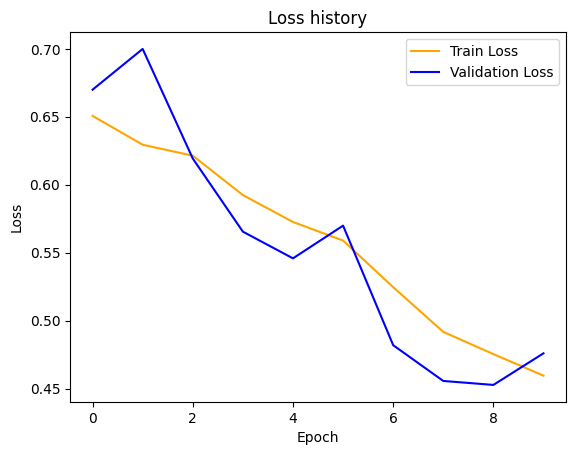

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Benchmark Training/Results Notes: ...

Accuracy on the Training set: 83.94%
Number of predictions:  660
Precision: 0.82, Recall: 0.97, F1 score: 0.89
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.92      0.58      0.71       226
           1       0.82      0.97      0.89       434

    accuracy                           0.84       660
   macro avg       0.87      0.78      0.80       660
weighted avg       0.85      0.84      0.83       660

Predicted lables:  [0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

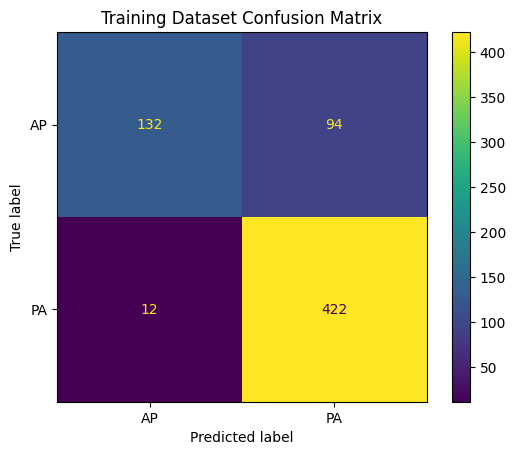

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 83.18%
Number of predictions:  220
Precision: 0.80, Recall: 0.98, F1 score: 0.88
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.94      0.57      0.71        80
           1       0.80      0.98      0.88       140

    accuracy                           0.83       220
   macro avg       0.87      0.78      0.80       220
weighted avg       0.85      0.83      0.82       220

Predicted lables:  [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1

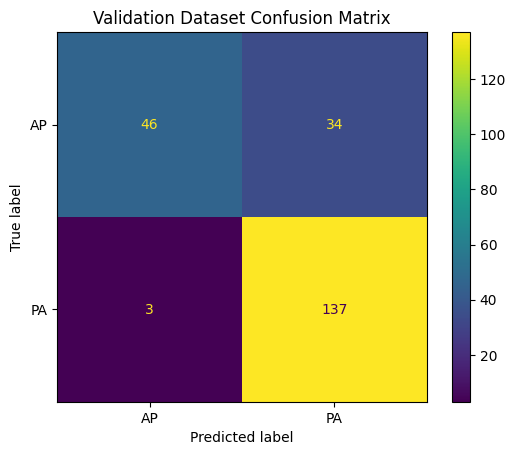

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

## 3 convolutional layers
### train macro accuracy = 40%; val macro accuracy = 39%

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# model hyperparameters
h = {
    "num_epochs": 10,
    "batch_size": 200,
    "image_size": 100,
    "fc1_size": 512,
    "lr": 0.001
}

# Create the model and optimizer
model = nn.Sequential(
  nn.Conv2d(1, 16, 3, stride = 1, padding = 1),
  # (input channels, output channels, filter size, stride, padding)
  # padding = 1 is similar to "padding=same" in keras
  # input channels --> number image color channels [grayscale: 1; rgb: 3]
  # output channels --> number of filters/kernels --> meaning number of neurons
  nn.ReLU(),
  # conv2D activation
  nn.MaxPool2d(2, 2),
  # image output shape reduced by factor of 2:  ex. before --> 1x56x56, after --> 1x28x28

  nn.Conv2d(16, 8, 3, stride = 1, padding = 1),
  # input channels should match previous convolutional layer
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  # flaaten image for fully connected layer

  nn.Conv2d(8, 3, 3, stride = 1, padding = 1),
  # input channels should match previous convolutional layer
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  # flaaten image for fully connected layer

  nn.Flatten(),

  nn.Linear(3 * (((h["image_size"] // 2) //2) //2) * (((h["image_size"] // 2) //2) //2), 512),
  # fully connected layer
  # (input_features, output_features)
  # input_features = number of features/filters from last conv2D layer * ( image channels * new height * new width)
  # ---> where new height & width = (conv height / (number of max pooling * max pooling factor))  = output after last max pool
  # output_features = number of neurons

  nn.ReLU(),
  # fully connected activation

  nn.Linear(512, 2),

  nn.Sigmoid()
  # output layer, classifies everything.
  # (input_features, output_features)
  # input_features = last layer's output --> meaning number of neurons
  # output_features
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(h['image_size'], h['batch_size'])

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

0.weight cuda:0
0.bias cuda:0
3.weight cuda:0
3.bias cuda:0
6.weight cuda:0
6.bias cuda:0
10.weight cuda:0
10.bias cuda:0
12.weight cuda:0
12.bias cuda:0

Training Dataset
Total batches: 4
Total samples: 660
Images per batch: 200

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
print(model)
print()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=432, out_features=512, bias=True)
  (11): ReLU()
  (12): Linear(in_features=512, out_features=2, bias=True)
  (13): Sigmoid()
)



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  226
Number of 1s (PA):  434
Validation
Number of 0s (AP):  80
Number of 1s (PA):  140


Epoch [1/10], Train Loss: 0.6829, Train Acc: 0.5879, Val Loss: 0.6556, Val Acc: 0.6364, Time: 10.63 sec
Epoch [2/10], Train Loss: 0.6597, Train Acc: 0.6576, Val Loss: 0.6476, Val Acc: 0.6364, Time: 9.87 sec
Epoch [3/10], Train Loss: 0.6527, Train Acc: 0.6576, Val Loss: 0.6910, Val Acc: 0.6364, Time: 8.97 sec
Epoch [4/10], Train Loss: 0.6326, Train Acc: 0.6576, Val Loss: 0.5977, Val Acc: 0.6364, Time: 8.66 sec
Epoch [5/10], Train Loss: 0.6189, Train Acc: 0.6576, Val Loss: 0.6832, Val Acc: 0.6364, Time: 8.30 sec
Epoch [6/10], Train Loss: 0.6444, Train Acc: 0.6576, Val Loss: 0.6300, Val Acc: 0.6364, Time: 8.93 sec
Epoch [7/10], Train Loss: 0.6444, Train Acc: 0.6576, Val Loss: 0.5961, Val Acc: 0.6364, Time: 8.91 sec
Epoch [8/10], Train Loss: 0.6297, Train Acc: 0.6576, Val Loss: 0.5859, Val Acc: 0.6364, Time: 8.43 sec
Epoch [9/10], Train Loss: 0.6336, Train Acc: 0.6576, Val Loss: 0.6565, Val Acc: 0.6364, Time: 8.88 sec
Epoch [10/10], Train Loss: 0.6153, Train Acc: 0.6576, Val Loss: 0.6606, 

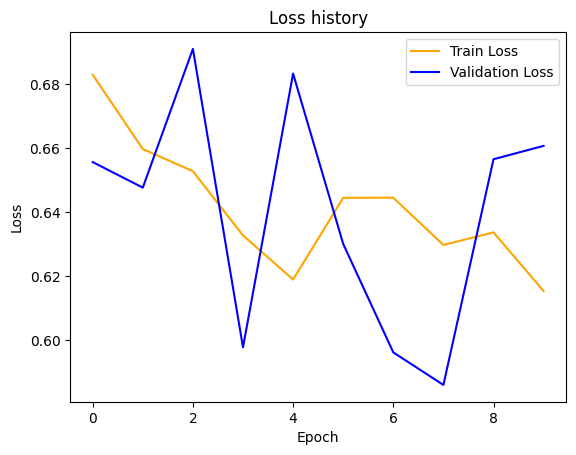

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Benchmark Training/Results Notes: ...

Accuracy on the Training set: 65.76%
Number of predictions:  660
Precision: 0.66, Recall: 1.00, F1 score: 0.79
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       226
           1       0.66      1.00      0.79       434

    accuracy                           0.66       660
   macro avg       0.33      0.50      0.40       660
weighted avg       0.43      0.66      0.52       660

Predicted lables:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


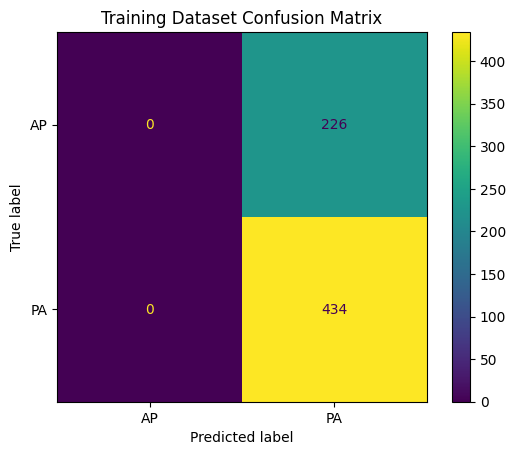

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 63.64%
Number of predictions:  220
Precision: 0.64, Recall: 1.00, F1 score: 0.78
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.64      1.00      0.78       140

    accuracy                           0.64       220
   macro avg       0.32      0.50      0.39       220
weighted avg       0.40      0.64      0.49       220

Predicted lables:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


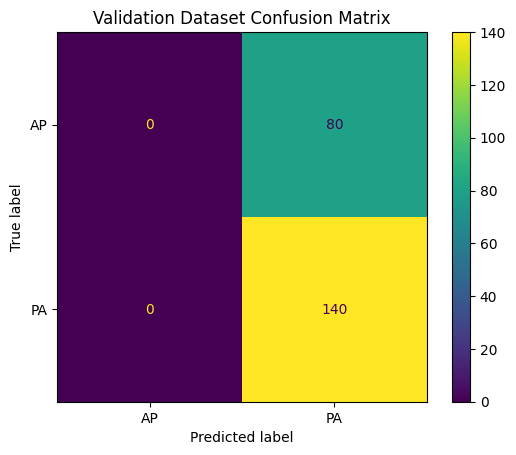

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

# <font color= 'blue'> Experiment 3: Conv2D Layer Neurons (16, 14, 15)

Tried different number of neurons in first convolutional layer, neurons for second convolutional layer kept constant at 8 neurons

*Description:*
- adam optimizer
- 100 image resize
- 200 batch size
- 2 convolutional layers, 2 fully connected layers


*Results:* Not much overfitting, with a model having 1% better accuracy on validation than training set -- seemed suspicious but re-checked preprocressing for any data leakage or other problems but did not find any, this may have been because the validation set is not very large so it may be easier to generalize predictions of only 220 images versus a training set of 660. Model performance also seems sensitive to number of neurons, even with change of 1 or 2 neurons.


*Best Model:* 15 neurons

## 16 neurons
### train macro accuracy = 83%; val macro accuracy = 84%

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# model hyperparameters
h = {
    "num_epochs": 10,
    "batch_size": 200,
    "image_size": 100,
    "fc1_size": 512,
    "lr": 0.001
}

# Create the model and optimizer
model = nn.Sequential(
  nn.Conv2d(1, 16, 3, stride = 1, padding = 1),
  # (input channels, output channels, filter size, stride, padding)
  # padding = 1 is similar to "padding=same" in keras
  # input channels --> number image color channels [grayscale: 1; rgb: 3]
  # output channels --> number of filters/kernels --> meaning number of neurons
  nn.ReLU(),
  # conv2D activation
  nn.MaxPool2d(2, 2),
  # image output shape reduced by factor of 2:  ex. before --> 1x56x56, after --> 1x28x28

  nn.Conv2d(16, 8, 3, stride = 1, padding = 1),
  # input channels should match previous convolutional layer
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  # flaaten image for fully connected layer
  nn.Flatten(),

  nn.Linear(8 * ((h["image_size"] // 2) //2) * ((h["image_size"] // 2) //2), 512),
  # fully connected layer
  # (input_features, output_features)
  # input_features = number of features/filters from last conv2D layer * ( image channels * new height * new width)
  # ---> where new height & width = (conv height / (number of max pooling * max pooling factor))  = output after last max pool
  # output_features = number of neurons

  nn.ReLU(),
  # fully connected activation

  nn.Linear(512, 2),

  nn.Sigmoid()
  # output layer, classifies everything.
  # (input_features, output_features)
  # input_features = last layer's output --> meaning number of neurons
  # output_features
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(h['image_size'], h['batch_size'])

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

0.weight cuda:0
0.bias cuda:0
3.weight cuda:0
3.bias cuda:0
7.weight cuda:0
7.bias cuda:0
9.weight cuda:0
9.bias cuda:0

Training Dataset
Total batches: 4
Total samples: 660
Images per batch: 200

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  226
Number of 1s (PA):  434
Validation
Number of 0s (AP):  80
Number of 1s (PA):  140


Epoch [1/10], Train Loss: 0.6783, Train Acc: 0.5424, Val Loss: 0.6721, Val Acc: 0.6364, Time: 9.30 sec
Epoch [2/10], Train Loss: 0.6330, Train Acc: 0.6576, Val Loss: 0.5863, Val Acc: 0.6364, Time: 8.24 sec
Epoch [3/10], Train Loss: 0.6103, Train Acc: 0.6576, Val Loss: 0.6114, Val Acc: 0.6364, Time: 8.97 sec
Epoch [4/10], Train Loss: 0.5980, Train Acc: 0.6576, Val Loss: 0.5599, Val Acc: 0.6364, Time: 9.00 sec
Epoch [5/10], Train Loss: 0.5738, Train Acc: 0.7076, Val Loss: 0.5580, Val Acc: 0.7455, Time: 8.09 sec
Epoch [6/10], Train Loss: 0.5512, Train Acc: 0.7121, Val Loss: 0.5771, Val Acc: 0.6864, Time: 8.96 sec
Epoch [7/10], Train Loss: 0.5400, Train Acc: 0.7742, Val Loss: 0.4916, Val Acc: 0.8636, Time: 8.99 sec
Epoch [8/10], Train Loss: 0.5124, Train Acc: 0.8136, Val Loss: 0.4835, Val Acc: 0.8227, Time: 8.96 sec
Epoch [9/10], Train Loss: 0.4869, Train Acc: 0.8348, Val Loss: 0.4484, Val Acc: 0.8909, Time: 8.52 sec
Epoch [10/10], Train Loss: 0.4661, Train Acc: 0.8500, Val Loss: 0.4278, V

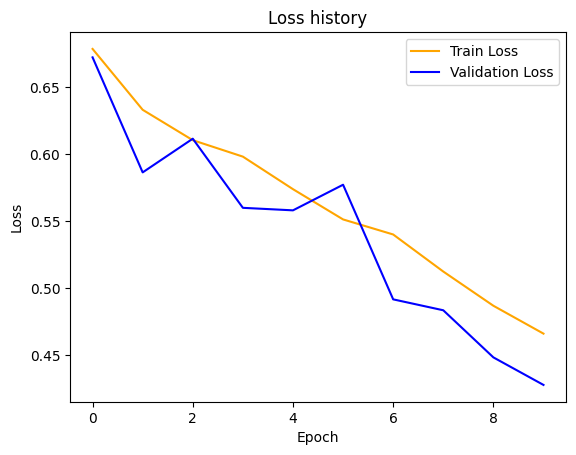

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Accuracy on the Training set: 85.61%
Number of predictions:  660
Precision: 0.85, Recall: 0.96, F1 score: 0.90
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       226
           1       0.85      0.96      0.90       434

    accuracy                           0.86       660
   macro avg       0.87      0.81      0.83       660
weighted avg       0.86      0.86      0.85       660

Predicted lables:  [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

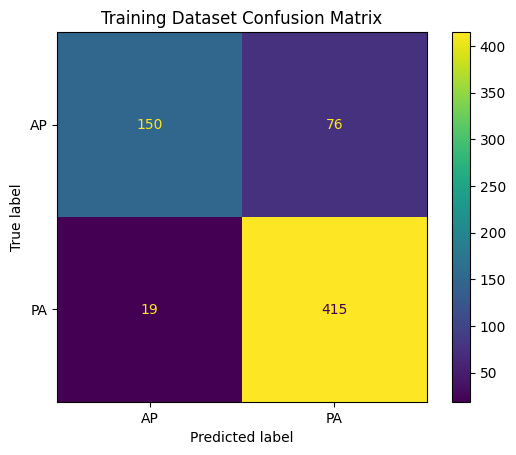

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 86.36%
Number of predictions:  220
Precision: 0.84, Recall: 0.98, F1 score: 0.90
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.95      0.66      0.78        80
           1       0.84      0.98      0.90       140

    accuracy                           0.86       220
   macro avg       0.89      0.82      0.84       220
weighted avg       0.88      0.86      0.86       220

Predicted lables:  [1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

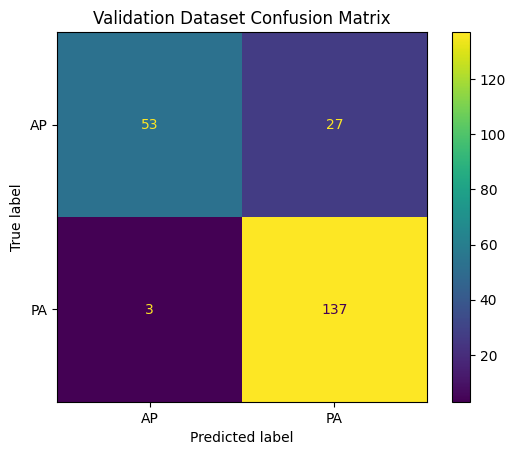

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

## 14 neurons
### train macro accuracy = 81%; val macro accuracy = 80%

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# model hyperparameters
h = {
    "num_epochs": 10,
    "batch_size": 200,
    "image_size": 100,
    "fc1_size": 512,
    "lr": 0.001
}

# Create the model and optimizer
model = nn.Sequential(
  nn.Conv2d(1, 14, 3, stride = 1, padding = 1),
  # (input channels, output channels, filter size, stride, padding)
  # padding = 1 is similar to "padding=same" in keras
  # input channels --> number image color channels [grayscale: 1; rgb: 3]
  # output channels --> number of filters/kernels --> meaning number of neurons
  nn.ReLU(),
  # conv2D activation
  nn.MaxPool2d(2, 2),
  # image output shape reduced by factor of 2:  ex. before --> 1x56x56, after --> 1x28x28

  nn.Conv2d(14, 8, 3, stride = 1, padding = 1),
  # input channels should match previous convolutional layer
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  # flaaten image for fully connected layer
  nn.Flatten(),

  nn.Linear(8 * ((h["image_size"] // 2) //2) * ((h["image_size"] // 2) //2), 512),
  # fully connected layer
  # (input_features, output_features)
  # input_features = number of features/filters from last conv2D layer * ( image channels * new height * new width)
  # ---> where new height & width = (conv height / (number of max pooling * max pooling factor))  = output after last max pool
  # output_features = number of neurons

  nn.ReLU(),
  # fully connected activation

  nn.Linear(512, 2),

  nn.Sigmoid()
  # output layer, classifies everything.
  # (input_features, output_features)
  # input_features = last layer's output --> meaning number of neurons
  # output_features
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(h['image_size'], h['batch_size'])

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

0.weight cuda:0
0.bias cuda:0
3.weight cuda:0
3.bias cuda:0
7.weight cuda:0
7.bias cuda:0
9.weight cuda:0
9.bias cuda:0

Training Dataset
Total batches: 4
Total samples: 660
Images per batch: 200

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  226
Number of 1s (PA):  434
Validation
Number of 0s (AP):  80
Number of 1s (PA):  140


Epoch [1/10], Train Loss: 0.6544, Train Acc: 0.5652, Val Loss: 0.7387, Val Acc: 0.6364, Time: 8.17 sec
Epoch [2/10], Train Loss: 0.6256, Train Acc: 0.6576, Val Loss: 0.6099, Val Acc: 0.6364, Time: 9.01 sec
Epoch [3/10], Train Loss: 0.6112, Train Acc: 0.6576, Val Loss: 0.6058, Val Acc: 0.6364, Time: 8.99 sec
Epoch [4/10], Train Loss: 0.5978, Train Acc: 0.6576, Val Loss: 0.5923, Val Acc: 0.6500, Time: 8.76 sec
Epoch [5/10], Train Loss: 0.5702, Train Acc: 0.7258, Val Loss: 0.5342, Val Acc: 0.7182, Time: 8.41 sec
Epoch [6/10], Train Loss: 0.5353, Train Acc: 0.7727, Val Loss: 0.5231, Val Acc: 0.8091, Time: 9.00 sec
Epoch [7/10], Train Loss: 0.5053, Train Acc: 0.7985, Val Loss: 0.4500, Val Acc: 0.8409, Time: 9.39 sec
Epoch [8/10], Train Loss: 0.4776, Train Acc: 0.8318, Val Loss: 0.4606, Val Acc: 0.8727, Time: 8.65 sec
Epoch [9/10], Train Loss: 0.4598, Train Acc: 0.8500, Val Loss: 0.4779, Val Acc: 0.8500, Time: 8.81 sec
Epoch [10/10], Train Loss: 0.4860, Train Acc: 0.8227, Val Loss: 0.4984, V

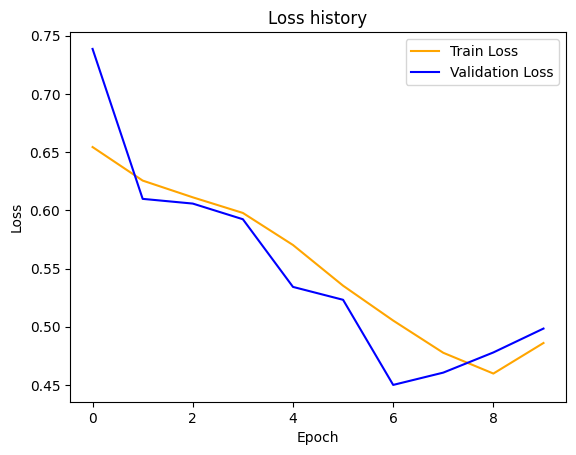

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Accuracy on the Training set: 84.55%
Number of predictions:  660
Precision: 0.83, Recall: 0.96, F1 score: 0.89
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.90      0.62      0.73       226
           1       0.83      0.96      0.89       434

    accuracy                           0.85       660
   macro avg       0.86      0.79      0.81       660
weighted avg       0.85      0.85      0.84       660

Predicted lables:  [1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,

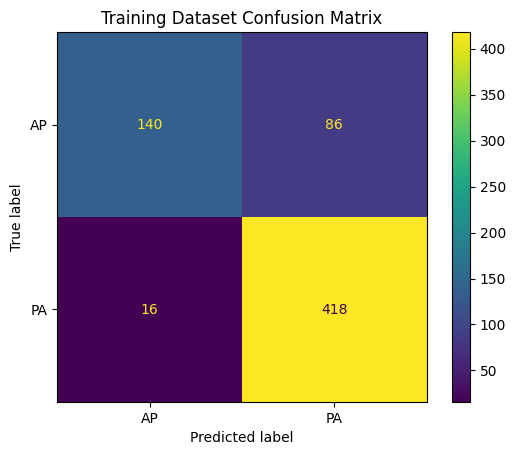

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 83.64%
Number of predictions:  220
Precision: 0.81, Recall: 0.98, F1 score: 0.88
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.94      0.59      0.72        80
           1       0.81      0.98      0.88       140

    accuracy                           0.84       220
   macro avg       0.87      0.78      0.80       220
weighted avg       0.85      0.84      0.83       220

Predicted lables:  [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0

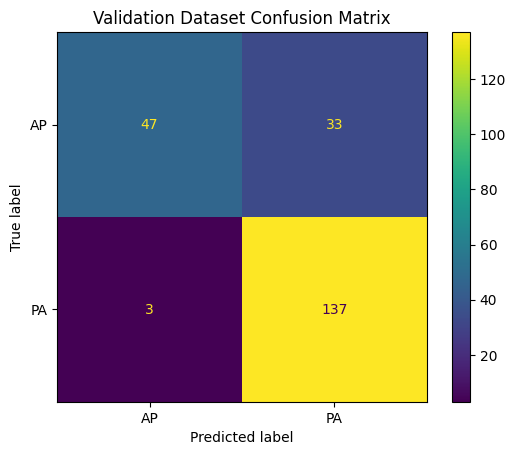

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

## 15 neurons
### train macro accuracy = 83%; val macro accuracy = 83%

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# model hyperparameters
h = {
    "num_epochs": 10,
    "batch_size": 200,
    "image_size": 100,
    "fc1_size": 512,
    "lr": 0.001
}

# Create the model and optimizer
model = nn.Sequential(
  nn.Conv2d(1, 15, 3, stride = 1, padding = 1),
  # (input channels, output channels, filter size, stride, padding)
  # padding = 1 is similar to "padding=same" in keras
  # input channels --> number image color channels [grayscale: 1; rgb: 3]
  # output channels --> number of filters/kernels --> meaning number of neurons
  nn.ReLU(),
  # conv2D activation
  nn.MaxPool2d(2, 2),
  # image output shape reduced by factor of 2:  ex. before --> 1x56x56, after --> 1x28x28

  nn.Conv2d(15, 8, 3, stride = 1, padding = 1),
  # input channels should match previous convolutional layer
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  # flaaten image for fully connected layer
  nn.Flatten(),

  nn.Linear(8 * ((h["image_size"] // 2) //2) * ((h["image_size"] // 2) //2), 512),
  # fully connected layer
  # (input_features, output_features)
  # input_features = number of features/filters from last conv2D layer * ( image channels * new height * new width)
  # ---> where new height & width = (conv height / (number of max pooling * max pooling factor))  = output after last max pool
  # output_features = number of neurons

  nn.ReLU(),
  # fully connected activation

  nn.Linear(512, 2),

  nn.Sigmoid()
  # output layer, classifies everything.
  # (input_features, output_features)
  # input_features = last layer's output --> meaning number of neurons
  # output_features
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(h['image_size'], h['batch_size'])

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

0.weight cuda:0
0.bias cuda:0
3.weight cuda:0
3.bias cuda:0
7.weight cuda:0
7.bias cuda:0
9.weight cuda:0
9.bias cuda:0

Training Dataset
Total batches: 4
Total samples: 660
Images per batch: 200

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  226
Number of 1s (PA):  434
Validation
Number of 0s (AP):  80
Number of 1s (PA):  140


Epoch [1/10], Train Loss: 0.6799, Train Acc: 0.6576, Val Loss: 0.6289, Val Acc: 0.6364, Time: 10.03 sec
Epoch [2/10], Train Loss: 0.6267, Train Acc: 0.6576, Val Loss: 0.6864, Val Acc: 0.6364, Time: 8.95 sec
Epoch [3/10], Train Loss: 0.6328, Train Acc: 0.6576, Val Loss: 0.5971, Val Acc: 0.6364, Time: 8.07 sec
Epoch [4/10], Train Loss: 0.6180, Train Acc: 0.6576, Val Loss: 0.5899, Val Acc: 0.6364, Time: 8.97 sec
Epoch [5/10], Train Loss: 0.6198, Train Acc: 0.6576, Val Loss: 0.6012, Val Acc: 0.6364, Time: 8.95 sec
Epoch [6/10], Train Loss: 0.5917, Train Acc: 0.6576, Val Loss: 0.5846, Val Acc: 0.6364, Time: 9.25 sec
Epoch [7/10], Train Loss: 0.5788, Train Acc: 0.6591, Val Loss: 0.5977, Val Acc: 0.6455, Time: 8.10 sec
Epoch [8/10], Train Loss: 0.5601, Train Acc: 0.7167, Val Loss: 0.5418, Val Acc: 0.8045, Time: 8.88 sec
Epoch [9/10], Train Loss: 0.5230, Train Acc: 0.7803, Val Loss: 0.5134, Val Acc: 0.8136, Time: 8.97 sec
Epoch [10/10], Train Loss: 0.5068, Train Acc: 0.8182, Val Loss: 0.4765, 

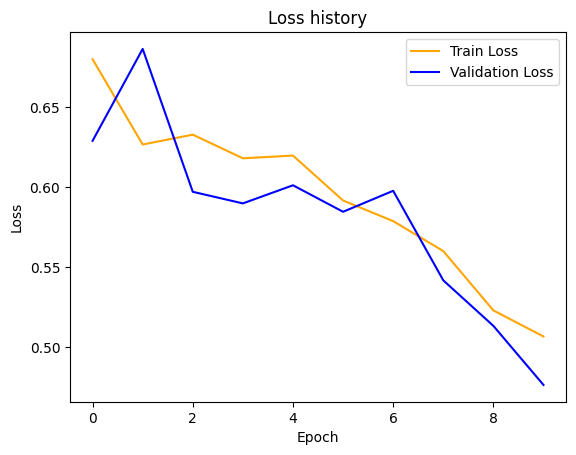

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Accuracy on the Training set: 85.00%
Number of predictions:  660
Precision: 0.88, Recall: 0.89, F1 score: 0.89
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       226
           1       0.88      0.89      0.89       434

    accuracy                           0.85       660
   macro avg       0.83      0.83      0.83       660
weighted avg       0.85      0.85      0.85       660

Predicted lables:  [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,

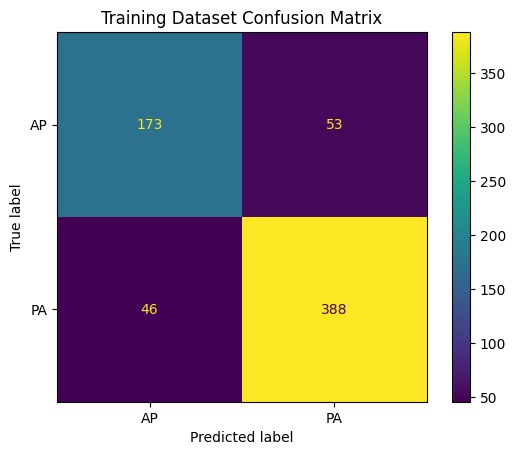

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 85.00%
Number of predictions:  220
Precision: 0.85, Recall: 0.93, F1 score: 0.89
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.85      0.71      0.78        80
           1       0.85      0.93      0.89       140

    accuracy                           0.85       220
   macro avg       0.85      0.82      0.83       220
weighted avg       0.85      0.85      0.85       220

Predicted lables:  [1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1

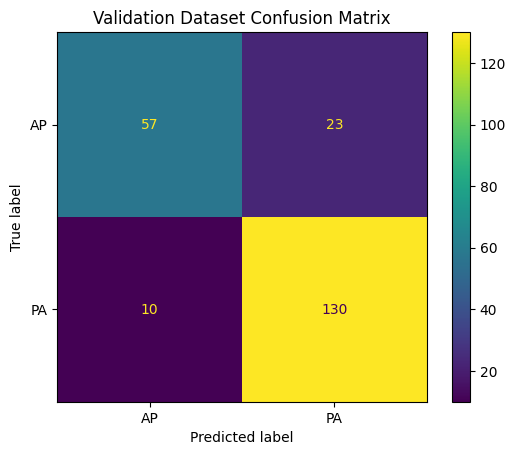

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

# <font color= 'blue'> Experiment 4: Image Size (120, 100, 70, 50)
Different image resizing as input to the model

*Description:*
- adam optimizer
- 200 batch size
- 2 convolutional layers (15 neurons, 8 neurons), 2 fully connected layers


*Results:* Model performance seems sensitive to image size, more overfitting in this experiment.


*Best Model:* 100 image size (was already being used as a constant from previous models)

## 70 image size
### train macro accuracy = 78%; val macro accuracy = 75%

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# model hyperparameters
h = {
    "num_epochs": 10,
    "batch_size": 200,
    "image_size": 70,
    "fc1_size": 512,
    "lr": 0.001
}

# Create the model and optimizer
model = nn.Sequential(
  nn.Conv2d(1, 15, 3, stride = 1, padding = 1),
  # (input channels, output channels, filter size, stride, padding)
  # padding = 1 is similar to "padding=same" in keras
  # input channels --> number image color channels [grayscale: 1; rgb: 3]
  # output channels --> number of filters/kernels --> meaning number of neurons
  nn.ReLU(),
  # conv2D activation
  nn.MaxPool2d(2, 2),
  # image output shape reduced by factor of 2:  ex. before --> 1x56x56, after --> 1x28x28

  nn.Conv2d(15, 8, 3, stride = 1, padding = 1),
  # input channels should match previous convolutional layer
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  # flaaten image for fully connected layer
  nn.Flatten(),

  nn.Linear(8 * ((h["image_size"] // 2) //2) * ((h["image_size"] // 2) //2), 512),
  # fully connected layer
  # (input_features, output_features)
  # input_features = number of features/filters from last conv2D layer * ( image channels * new height * new width)
  # ---> where new height & width = (conv height / (number of max pooling * max pooling factor))  = output after last max pool
  # output_features = number of neurons

  nn.ReLU(),
  # fully connected activation

  nn.Linear(512, 2),

  nn.Sigmoid()
  # output layer, classifies everything.
  # (input_features, output_features)
  # input_features = last layer's output --> meaning number of neurons
  # output_features
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(h['image_size'], h['batch_size'])

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

0.weight cuda:0
0.bias cuda:0
3.weight cuda:0
3.bias cuda:0
7.weight cuda:0
7.bias cuda:0
9.weight cuda:0
9.bias cuda:0

Training Dataset
Total batches: 4
Total samples: 660
Images per batch: 200

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  226
Number of 1s (PA):  434
Validation
Number of 0s (AP):  80
Number of 1s (PA):  140


Epoch [1/10], Train Loss: 0.6847, Train Acc: 0.5485, Val Loss: 0.6310, Val Acc: 0.6364, Time: 8.77 sec
Epoch [2/10], Train Loss: 0.6315, Train Acc: 0.6576, Val Loss: 0.6398, Val Acc: 0.6364, Time: 7.87 sec
Epoch [3/10], Train Loss: 0.6289, Train Acc: 0.6576, Val Loss: 0.6822, Val Acc: 0.6364, Time: 8.73 sec
Epoch [4/10], Train Loss: 0.6256, Train Acc: 0.6576, Val Loss: 0.6402, Val Acc: 0.6364, Time: 8.69 sec
Epoch [5/10], Train Loss: 0.6081, Train Acc: 0.6576, Val Loss: 0.6302, Val Acc: 0.6364, Time: 8.10 sec
Epoch [6/10], Train Loss: 0.5855, Train Acc: 0.6894, Val Loss: 0.5695, Val Acc: 0.6955, Time: 8.45 sec
Epoch [7/10], Train Loss: 0.5523, Train Acc: 0.7394, Val Loss: 0.5375, Val Acc: 0.8273, Time: 9.15 sec
Epoch [8/10], Train Loss: 0.5169, Train Acc: 0.8076, Val Loss: 0.5900, Val Acc: 0.7500, Time: 8.69 sec
Epoch [9/10], Train Loss: 0.5133, Train Acc: 0.7955, Val Loss: 0.4829, Val Acc: 0.8636, Time: 7.86 sec
Epoch [10/10], Train Loss: 0.4920, Train Acc: 0.8076, Val Loss: 0.4847, V

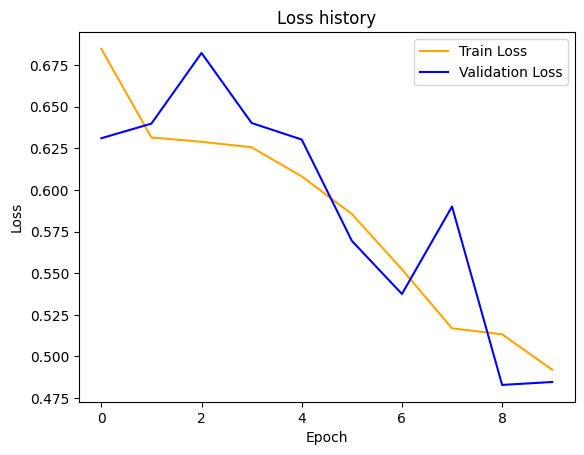

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Accuracy on the Training set: 82.58%
Number of predictions:  660
Precision: 0.81, Recall: 0.96, F1 score: 0.88
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.89      0.56      0.69       226
           1       0.81      0.96      0.88       434

    accuracy                           0.83       660
   macro avg       0.85      0.76      0.78       660
weighted avg       0.84      0.83      0.81       660

Predicted lables:  [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,

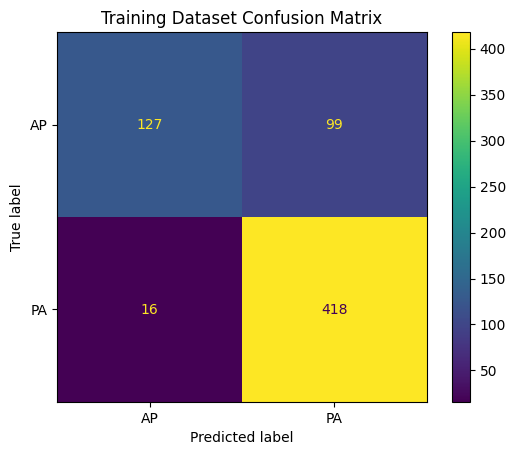

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 80.45%
Number of predictions:  220
Precision: 0.77, Recall: 0.99, F1 score: 0.87
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.97      0.47      0.64        80
           1       0.77      0.99      0.87       140

    accuracy                           0.80       220
   macro avg       0.87      0.73      0.75       220
weighted avg       0.84      0.80      0.78       220

Predicted lables:  [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1

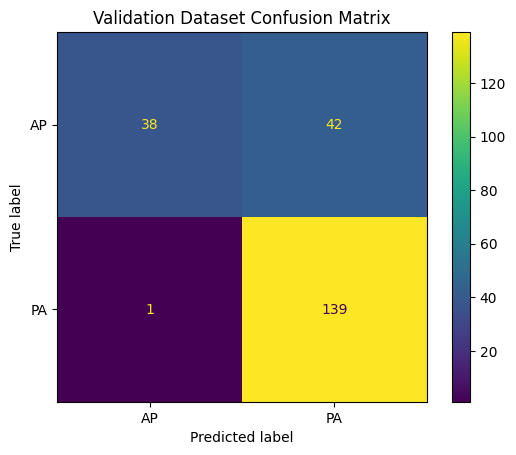

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

## 50 image size
### train macro accuracy = 77%; val macro accuracy = 80%

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# model hyperparameters
h = {
    "num_epochs": 10,
    "batch_size": 200,
    "image_size": 70,
    "fc1_size": 512,
    "lr": 0.001
}

# Create the model and optimizer
model = nn.Sequential(
  nn.Conv2d(1, 14, 3, stride = 1, padding = 1),
  # (input channels, output channels, filter size, stride, padding)
  # padding = 1 is similar to "padding=same" in keras
  # input channels --> number image color channels [grayscale: 1; rgb: 3]
  # output channels --> number of filters/kernels --> meaning number of neurons
  nn.ReLU(),
  # conv2D activation
  nn.MaxPool2d(2, 2),
  # image output shape reduced by factor of 2:  ex. before --> 1x56x56, after --> 1x28x28

  nn.Conv2d(14, 8, 3, stride = 1, padding = 1),
  # input channels should match previous convolutional layer
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  # flaaten image for fully connected layer
  nn.Flatten(),

  nn.Linear(8 * ((h["image_size"] // 2) //2) * ((h["image_size"] // 2) //2), 512),
  # fully connected layer
  # (input_features, output_features)
  # input_features = number of features/filters from last conv2D layer * ( image channels * new height * new width)
  # ---> where new height & width = (conv height / (number of max pooling * max pooling factor))  = output after last max pool
  # output_features = number of neurons

  nn.ReLU(),
  # fully connected activation

  nn.Linear(512, 2),

  nn.Sigmoid()
  # output layer, classifies everything.
  # (input_features, output_features)
  # input_features = last layer's output --> meaning number of neurons
  # output_features
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(h['image_size'], h['batch_size'])

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

0.weight cuda:0
0.bias cuda:0
3.weight cuda:0
3.bias cuda:0
7.weight cuda:0
7.bias cuda:0
9.weight cuda:0
9.bias cuda:0

Training Dataset
Total batches: 4
Total samples: 660
Images per batch: 200

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  226
Number of 1s (PA):  434
Validation
Number of 0s (AP):  80
Number of 1s (PA):  140


Epoch [1/10], Train Loss: 0.6554, Train Acc: 0.6576, Val Loss: 0.5756, Val Acc: 0.6364, Time: 8.20 sec
Epoch [2/10], Train Loss: 0.6441, Train Acc: 0.6576, Val Loss: 0.6234, Val Acc: 0.6364, Time: 9.12 sec
Epoch [3/10], Train Loss: 0.6268, Train Acc: 0.6576, Val Loss: 0.6232, Val Acc: 0.6364, Time: 8.91 sec
Epoch [4/10], Train Loss: 0.6306, Train Acc: 0.6576, Val Loss: 0.6167, Val Acc: 0.6364, Time: 8.64 sec
Epoch [5/10], Train Loss: 0.6059, Train Acc: 0.6576, Val Loss: 0.6039, Val Acc: 0.6364, Time: 8.23 sec
Epoch [6/10], Train Loss: 0.5973, Train Acc: 0.6576, Val Loss: 0.5909, Val Acc: 0.6364, Time: 9.37 sec
Epoch [7/10], Train Loss: 0.5718, Train Acc: 0.7045, Val Loss: 0.5487, Val Acc: 0.8409, Time: 8.76 sec
Epoch [8/10], Train Loss: 0.5284, Train Acc: 0.8045, Val Loss: 0.4929, Val Acc: 0.7500, Time: 7.89 sec
Epoch [9/10], Train Loss: 0.5110, Train Acc: 0.7955, Val Loss: 0.5099, Val Acc: 0.8818, Time: 8.77 sec
Epoch [10/10], Train Loss: 0.5157, Train Acc: 0.7985, Val Loss: 0.4872, V

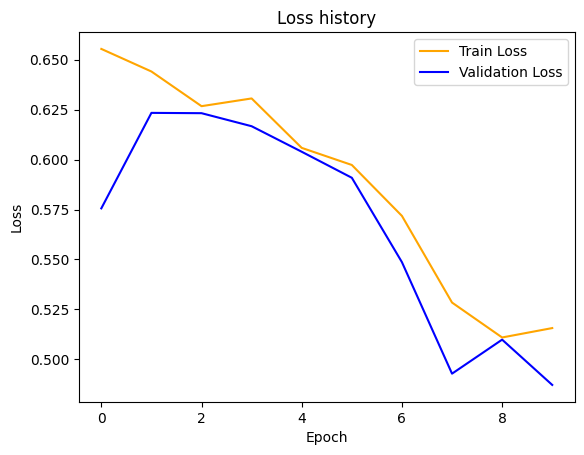

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Accuracy on the Training set: 81.52%
Number of predictions:  660
Precision: 0.81, Recall: 0.94, F1 score: 0.87
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.84      0.57      0.68       226
           1       0.81      0.94      0.87       434

    accuracy                           0.82       660
   macro avg       0.82      0.76      0.77       660
weighted avg       0.82      0.82      0.80       660

Predicted lables:  [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,

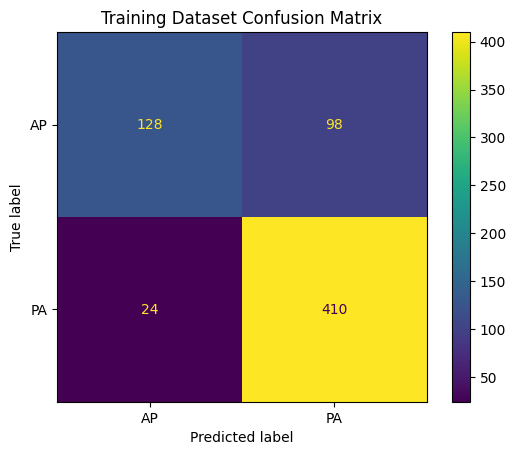

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 83.64%
Number of predictions:  220
Precision: 0.81, Recall: 0.98, F1 score: 0.88
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.94      0.59      0.72        80
           1       0.81      0.98      0.88       140

    accuracy                           0.84       220
   macro avg       0.87      0.78      0.80       220
weighted avg       0.85      0.84      0.83       220

Predicted lables:  [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1

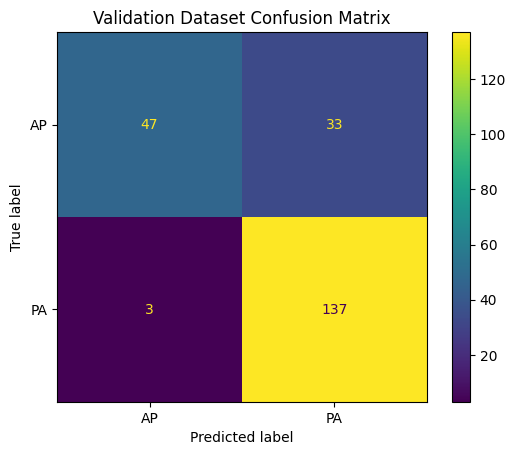

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

## 120 image size
### train macro accuracy = 77%; val macro accuracy = 76%

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# model hyperparameters
h = {
    "num_epochs": 10,
    "batch_size": 200,
    "image_size": 120,
    "fc1_size": 512,
    "lr": 0.001
}

# Create the model and optimizer
model = nn.Sequential(
  nn.Conv2d(1, 15, 3, stride = 1, padding = 1),
  # (input channels, output channels, filter size, stride, padding)
  # padding = 1 is similar to "padding=same" in keras
  # input channels --> number image color channels [grayscale: 1; rgb: 3]
  # output channels --> number of filters/kernels --> meaning number of neurons
  nn.ReLU(),
  # conv2D activation
  nn.MaxPool2d(2, 2),
  # image output shape reduced by factor of 2:  ex. before --> 1x56x56, after --> 1x28x28

  nn.Conv2d(15, 8, 3, stride = 1, padding = 1),
  # input channels should match previous convolutional layer
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  # flaaten image for fully connected layer
  nn.Flatten(),

  nn.Linear(8 * ((h["image_size"] // 2) //2) * ((h["image_size"] // 2) //2), 512),
  # fully connected layer
  # (input_features, output_features)
  # input_features = number of features/filters from last conv2D layer * ( image channels * new height * new width)
  # ---> where new height & width = (conv height / (number of max pooling * max pooling factor))  = output after last max pool
  # output_features = number of neurons

  nn.ReLU(),
  # fully connected activation

  nn.Linear(512, 2),

  nn.Sigmoid()
  # output layer, classifies everything.
  # (input_features, output_features)
  # input_features = last layer's output --> meaning number of neurons
  # output_features
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(h['image_size'], h['batch_size'])

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

0.weight cuda:0
0.bias cuda:0
3.weight cuda:0
3.bias cuda:0
7.weight cuda:0
7.bias cuda:0
9.weight cuda:0
9.bias cuda:0

Training Dataset
Total batches: 4
Total samples: 660
Images per batch: 200

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  226
Number of 1s (PA):  434
Validation
Number of 0s (AP):  80
Number of 1s (PA):  140


Epoch [1/10], Train Loss: 0.6433, Train Acc: 0.5955, Val Loss: 0.7650, Val Acc: 0.6364, Time: 10.54 sec
Epoch [2/10], Train Loss: 0.6300, Train Acc: 0.6576, Val Loss: 0.6344, Val Acc: 0.6364, Time: 8.41 sec
Epoch [3/10], Train Loss: 0.6215, Train Acc: 0.6576, Val Loss: 0.5549, Val Acc: 0.6364, Time: 9.27 sec
Epoch [4/10], Train Loss: 0.5986, Train Acc: 0.6576, Val Loss: 0.5765, Val Acc: 0.6364, Time: 9.34 sec
Epoch [5/10], Train Loss: 0.5690, Train Acc: 0.6621, Val Loss: 0.5138, Val Acc: 0.7045, Time: 9.07 sec
Epoch [6/10], Train Loss: 0.5439, Train Acc: 0.7364, Val Loss: 0.5745, Val Acc: 0.7955, Time: 8.56 sec
Epoch [7/10], Train Loss: 0.5464, Train Acc: 0.7773, Val Loss: 0.5713, Val Acc: 0.6864, Time: 9.32 sec
Epoch [8/10], Train Loss: 0.5163, Train Acc: 0.7879, Val Loss: 0.5111, Val Acc: 0.8045, Time: 9.23 sec
Epoch [9/10], Train Loss: 0.5442, Train Acc: 0.7697, Val Loss: 0.5263, Val Acc: 0.7545, Time: 9.53 sec
Epoch [10/10], Train Loss: 0.5289, Train Acc: 0.7697, Val Loss: 0.5129, 

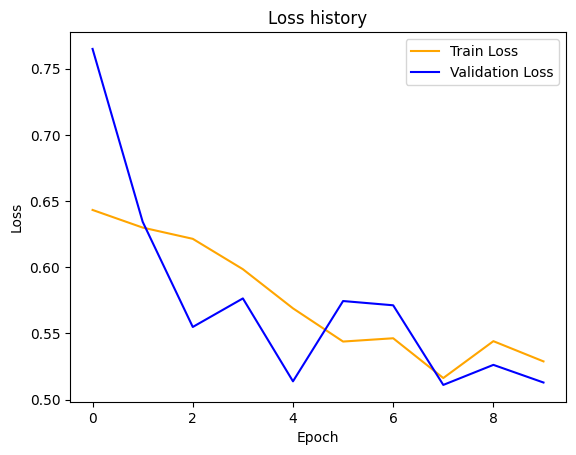

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Accuracy on the Training set: 81.52%
Number of predictions:  660
Precision: 0.80, Recall: 0.96, F1 score: 0.87
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.88      0.53      0.66       226
           1       0.80      0.96      0.87       434

    accuracy                           0.82       660
   macro avg       0.84      0.75      0.77       660
weighted avg       0.83      0.82      0.80       660

Predicted lables:  [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,

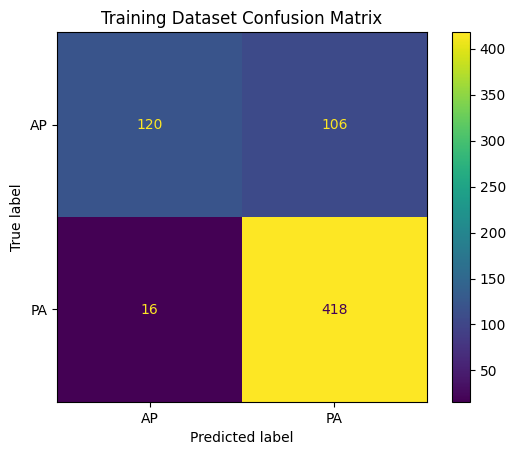

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 80.91%
Number of predictions:  220
Precision: 0.77, Recall: 0.99, F1 score: 0.87
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.97      0.49      0.65        80
           1       0.77      0.99      0.87       140

    accuracy                           0.81       220
   macro avg       0.87      0.74      0.76       220
weighted avg       0.85      0.81      0.79       220

Predicted lables:  [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1

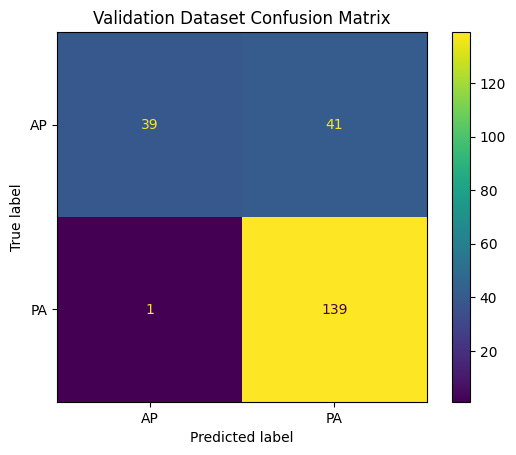

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

# <font color= 'blue'> Experiment 5: Dropout Rate (0, 0.2, 0.1)

Introduced dropout rate after both convolutional layers.

*Description:*
- adam optimizer
- 100 image resize
- 200 batch size
- 2 convolutional layers (15 neurons, 8 neurons), 2 fully connected layers


*Results:* Dropout did not improve model performance or address overfitting by much.


*Best Model:* 0 Dropout Rate (was already being used as a constant from previous models)

## 0.2 Dropout
### train macro accuracy = 78%; val macro accuracy = 82%

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# model hyperparameters
h = {
    "num_epochs": 10,
    "batch_size": 200,
    "image_size": 100,
    "fc1_size": 512,
    "lr": 0.001
}

# Create the model and optimizer
model = nn.Sequential(
  nn.Conv2d(1, 15, 3, stride = 1, padding = 1),
  # (input channels, output channels, filter size, stride, padding)
  # padding = 1 is similar to "padding=same" in keras
  # input channels --> number image color channels [grayscale: 1; rgb: 3]
  # output channels --> number of filters/kernels --> meaning number of neurons
  nn.ReLU(),
  # conv2D activation
  nn.MaxPool2d(2, 2),
  nn.Dropout(0.2),
  # image output shape reduced by factor of 2:  ex. before --> 1x56x56, after --> 1x28x28

  nn.Conv2d(15, 8, 3, stride = 1, padding = 1),
  # input channels should match previous convolutional layer
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  nn.Dropout(0.2),
  # flaaten image for fully connected layer
  nn.Flatten(),

  nn.Linear(8 * ((h["image_size"] // 2) //2) * ((h["image_size"] // 2) //2), 512),
  # fully connected layer
  # (input_features, output_features)
  # input_features = number of features/filters from last conv2D layer * ( image channels * new height * new width)
  # ---> where new height & width = (conv height / (number of max pooling * max pooling factor))  = output after last max pool
  # output_features = number of neurons

  nn.ReLU(),
  # fully connected activation

  nn.Linear(512, 2),

  nn.Sigmoid()
  # output layer, classifies everything.
  # (input_features, output_features)
  # input_features = last layer's output --> meaning number of neurons
  # output_features
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(h['image_size'], h['batch_size'])

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

0.weight cuda:0
0.bias cuda:0
4.weight cuda:0
4.bias cuda:0
9.weight cuda:0
9.bias cuda:0
11.weight cuda:0
11.bias cuda:0

Training Dataset
Total batches: 4
Total samples: 660
Images per batch: 200

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  226
Number of 1s (PA):  434
Validation
Number of 0s (AP):  80
Number of 1s (PA):  140


Epoch [1/10], Train Loss: 0.6771, Train Acc: 0.5773, Val Loss: 0.5971, Val Acc: 0.6364, Time: 13.94 sec
Epoch [2/10], Train Loss: 0.6365, Train Acc: 0.6576, Val Loss: 0.6726, Val Acc: 0.6364, Time: 8.87 sec
Epoch [3/10], Train Loss: 0.6347, Train Acc: 0.6576, Val Loss: 0.6439, Val Acc: 0.6364, Time: 8.93 sec
Epoch [4/10], Train Loss: 0.6374, Train Acc: 0.6576, Val Loss: 0.6548, Val Acc: 0.6364, Time: 8.52 sec
Epoch [5/10], Train Loss: 0.6170, Train Acc: 0.6576, Val Loss: 0.5987, Val Acc: 0.6364, Time: 9.23 sec
Epoch [6/10], Train Loss: 0.5986, Train Acc: 0.6636, Val Loss: 0.6212, Val Acc: 0.6545, Time: 10.70 sec
Epoch [7/10], Train Loss: 0.5867, Train Acc: 0.6773, Val Loss: 0.5661, Val Acc: 0.7091, Time: 9.83 sec
Epoch [8/10], Train Loss: 0.5615, Train Acc: 0.7636, Val Loss: 0.5559, Val Acc: 0.7455, Time: 10.08 sec
Epoch [9/10], Train Loss: 0.5206, Train Acc: 0.7924, Val Loss: 0.5433, Val Acc: 0.7909, Time: 9.12 sec
Epoch [10/10], Train Loss: 0.5053, Train Acc: 0.8000, Val Loss: 0.4928

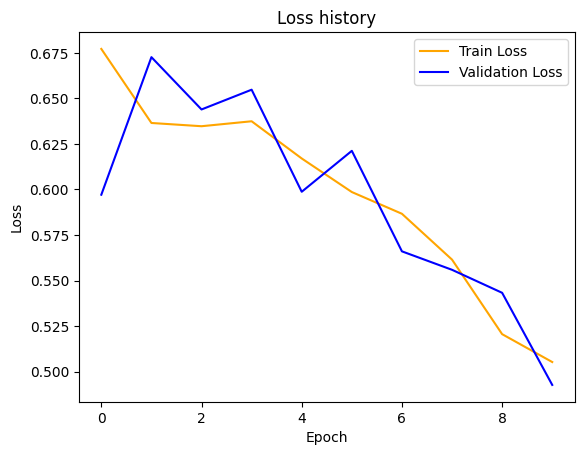

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Benchmark Training/Results Notes: ...

Accuracy on the Training set: 80.15%
Number of predictions:  660
Precision: 0.84, Recall: 0.86, F1 score: 0.85
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       226
           1       0.84      0.86      0.85       434

    accuracy                           0.80       660
   macro avg       0.78      0.77      0.78       660
weighted avg       0.80      0.80      0.80       660

Predicted lables:  [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,

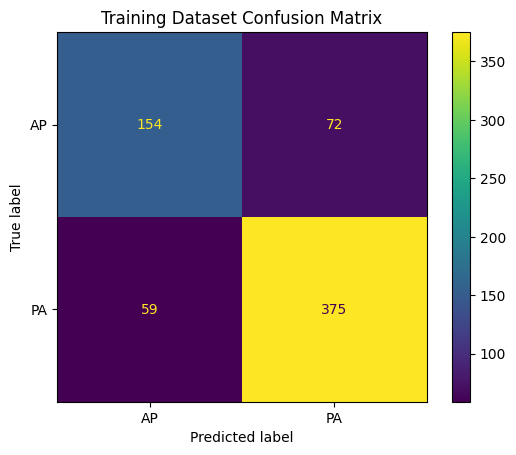

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 84.09%
Number of predictions:  220
Precision: 0.83, Recall: 0.94, F1 score: 0.88
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.87      0.66      0.75        80
           1       0.83      0.94      0.88       140

    accuracy                           0.84       220
   macro avg       0.85      0.80      0.82       220
weighted avg       0.84      0.84      0.84       220

Predicted lables:  [1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1

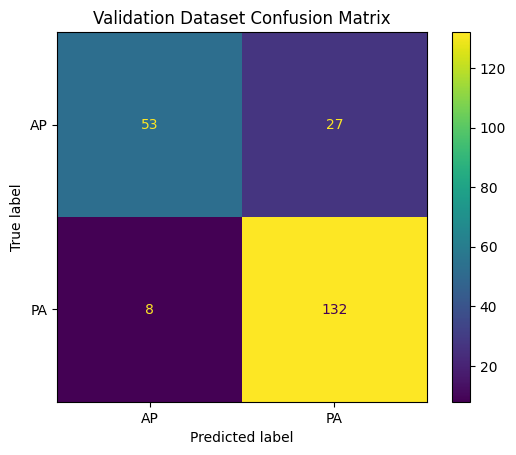

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

## 0.1 Dropout
### train macro accuracy = 82%; val macro accuracy = 85%

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# model hyperparameters
h = {
    "num_epochs": 10,
    "batch_size": 200,
    "image_size": 100,
    "fc1_size": 512,
    "lr": 0.001
}

# Create the model and optimizer
model = nn.Sequential(
  nn.Conv2d(1, 15, 3, stride = 1, padding = 1),
  # (input channels, output channels, filter size, stride, padding)
  # padding = 1 is similar to "padding=same" in keras
  # input channels --> number image color channels [grayscale: 1; rgb: 3]
  # output channels --> number of filters/kernels --> meaning number of neurons
  nn.ReLU(),
  # conv2D activation
  nn.MaxPool2d(2, 2),
  nn.Dropout(0.1),
  # image output shape reduced by factor of 2:  ex. before --> 1x56x56, after --> 1x28x28

  nn.Conv2d(15, 8, 3, stride = 1, padding = 1),
  # input channels should match previous convolutional layer
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  nn.Dropout(0.1),
  # flaaten image for fully connected layer
  nn.Flatten(),

  nn.Linear(8 * ((h["image_size"] // 2) //2) * ((h["image_size"] // 2) //2), 512),
  # fully connected layer
  # (input_features, output_features)
  # input_features = number of features/filters from last conv2D layer * ( image channels * new height * new width)
  # ---> where new height & width = (conv height / (number of max pooling * max pooling factor))  = output after last max pool
  # output_features = number of neurons

  nn.ReLU(),
  # fully connected activation

  nn.Linear(512, 2),

  nn.Sigmoid()
  # output layer, classifies everything.
  # (input_features, output_features)
  # input_features = last layer's output --> meaning number of neurons
  # output_features
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(h['image_size'], h['batch_size'])

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

0.weight cuda:0
0.bias cuda:0
4.weight cuda:0
4.bias cuda:0
9.weight cuda:0
9.bias cuda:0
11.weight cuda:0
11.bias cuda:0

Training Dataset
Total batches: 4
Total samples: 660
Images per batch: 200

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  226
Number of 1s (PA):  434
Validation
Number of 0s (AP):  80
Number of 1s (PA):  140


Epoch [1/10], Train Loss: 0.6497, Train Acc: 0.5636, Val Loss: 0.5850, Val Acc: 0.6364, Time: 9.76 sec
Epoch [2/10], Train Loss: 0.6382, Train Acc: 0.6576, Val Loss: 0.6201, Val Acc: 0.6364, Time: 9.76 sec
Epoch [3/10], Train Loss: 0.6261, Train Acc: 0.6576, Val Loss: 0.6317, Val Acc: 0.6364, Time: 9.72 sec
Epoch [4/10], Train Loss: 0.6068, Train Acc: 0.6576, Val Loss: 0.5879, Val Acc: 0.6364, Time: 9.72 sec
Epoch [5/10], Train Loss: 0.6039, Train Acc: 0.6576, Val Loss: 0.6363, Val Acc: 0.6955, Time: 9.12 sec
Epoch [6/10], Train Loss: 0.5816, Train Acc: 0.6924, Val Loss: 0.5795, Val Acc: 0.8727, Time: 9.73 sec
Epoch [7/10], Train Loss: 0.5331, Train Acc: 0.8227, Val Loss: 0.5236, Val Acc: 0.8591, Time: 9.70 sec
Epoch [8/10], Train Loss: 0.5218, Train Acc: 0.7924, Val Loss: 0.4833, Val Acc: 0.8591, Time: 9.76 sec
Epoch [9/10], Train Loss: 0.5035, Train Acc: 0.8091, Val Loss: 0.4705, Val Acc: 0.8409, Time: 8.97 sec
Epoch [10/10], Train Loss: 0.4888, Train Acc: 0.8303, Val Loss: 0.4970, V

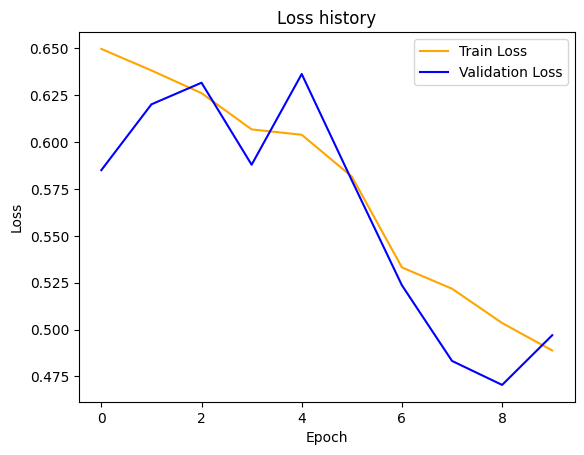

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Accuracy on the Training set: 84.55%
Number of predictions:  660
Precision: 0.85, Recall: 0.93, F1 score: 0.89
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.84      0.68      0.75       226
           1       0.85      0.93      0.89       434

    accuracy                           0.85       660
   macro avg       0.84      0.81      0.82       660
weighted avg       0.85      0.85      0.84       660

Predicted lables:  [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,

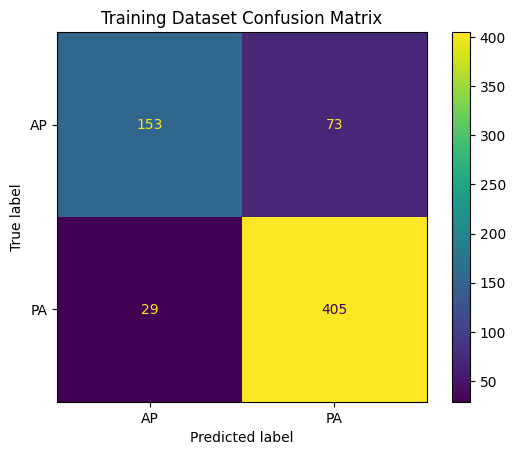

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 87.27%
Number of predictions:  220
Precision: 0.85, Recall: 0.98, F1 score: 0.91
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.95      0.69      0.80        80
           1       0.85      0.98      0.91       140

    accuracy                           0.87       220
   macro avg       0.90      0.83      0.85       220
weighted avg       0.88      0.87      0.87       220

Predicted lables:  [1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1

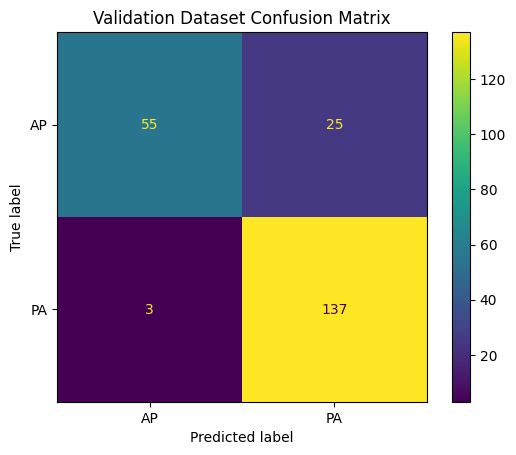

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

# <font color= 'blue'> Experiment 6: Batch Size (100, 200, 80)
Re-tested batch sizes from experiment 1 now that model was learning properly with convolutional layers

*Description:*
- adam optimizer
- 100 image resize
- 2 convolutional layers (15 neurons, 8 neurons), 2 fully connected layers
- 0 dropout rate


*Results:* Modifying batch size made big difference for model performance (increased by around 7%)


*Best Model:* 100 batch size

## 100 batch size
### train macro accuracy = 89%; val macro accuracy = 87%

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# model hyperparameters
h = {
    "num_epochs": 10,
    "batch_size": 100,
    "image_size": 100,
    "fc1_size": 512,
    "lr": 0.001
}

# Create the model and optimizer
model = nn.Sequential(
  nn.Conv2d(1, 15, 3, stride = 1, padding = 1),
  # (input channels, output channels, filter size, stride, padding)
  # padding = 1 is similar to "padding=same" in keras
  # input channels --> number image color channels [grayscale: 1; rgb: 3]
  # output channels --> number of filters/kernels --> meaning number of neurons
  nn.ReLU(),
  # conv2D activation
  nn.MaxPool2d(2, 2),
  # image output shape reduced by factor of 2:  ex. before --> 1x56x56, after --> 1x28x28

  nn.Conv2d(15, 8, 3, stride = 1, padding = 1),
  # input channels should match previous convolutional layer
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  # flaaten image for fully connected layer
  nn.Flatten(),

  nn.Linear(8 * ((h["image_size"] // 2) //2) * ((h["image_size"] // 2) //2), 512),
  # fully connected layer
  # (input_features, output_features)
  # input_features = number of features/filters from last conv2D layer * ( image channels * new height * new width)
  # ---> where new height & width = (conv height / (number of max pooling * max pooling factor))  = output after last max pool
  # output_features = number of neurons

  nn.ReLU(),
  # fully connected activation

  nn.Linear(512, 2),

  nn.Sigmoid()
  # output layer, classifies everything.
  # (input_features, output_features)
  # input_features = last layer's output --> meaning number of neurons
  # output_features
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(h['image_size'], h['batch_size'])

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

0.weight cuda:0
0.bias cuda:0
3.weight cuda:0
3.bias cuda:0
7.weight cuda:0
7.bias cuda:0
9.weight cuda:0
9.bias cuda:0

Training Dataset
Total batches: 7
Total samples: 660
Images per batch: 100

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  220
Number of 1s (PA):  440
Validation
Number of 0s (AP):  76
Number of 1s (PA):  144


Epoch [1/10], Train Loss: 0.6378, Train Acc: 0.6152, Val Loss: 0.6211, Val Acc: 0.6545, Time: 8.93 sec
Epoch [2/10], Train Loss: 0.6271, Train Acc: 0.6667, Val Loss: 0.6018, Val Acc: 0.6545, Time: 9.43 sec
Epoch [3/10], Train Loss: 0.6163, Train Acc: 0.6667, Val Loss: 0.6085, Val Acc: 0.6545, Time: 8.12 sec
Epoch [4/10], Train Loss: 0.5986, Train Acc: 0.6667, Val Loss: 0.5760, Val Acc: 0.6545, Time: 9.26 sec
Epoch [5/10], Train Loss: 0.5652, Train Acc: 0.7015, Val Loss: 0.5343, Val Acc: 0.7955, Time: 9.02 sec
Epoch [6/10], Train Loss: 0.5222, Train Acc: 0.8061, Val Loss: 0.5069, Val Acc: 0.7500, Time: 15.46 sec
Epoch [7/10], Train Loss: 0.4781, Train Acc: 0.8273, Val Loss: 0.4664, Val Acc: 0.8091, Time: 15.27 sec
Epoch [8/10], Train Loss: 0.4702, Train Acc: 0.8394, Val Loss: 0.5024, Val Acc: 0.8000, Time: 13.17 sec
Epoch [9/10], Train Loss: 0.4585, Train Acc: 0.8515, Val Loss: 0.4644, Val Acc: 0.8364, Time: 8.98 sec
Epoch [10/10], Train Loss: 0.4368, Train Acc: 0.8712, Val Loss: 0.4088

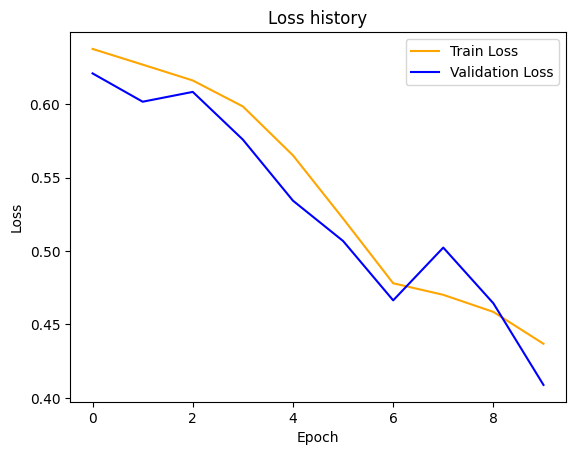

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Accuracy on the Training set: 90.00%
Number of predictions:  660
Precision: 0.92, Recall: 0.93, F1 score: 0.93
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       220
           1       0.92      0.93      0.93       440

    accuracy                           0.90       660
   macro avg       0.89      0.88      0.89       660
weighted avg       0.90      0.90      0.90       660

Predicted lables:  [1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,

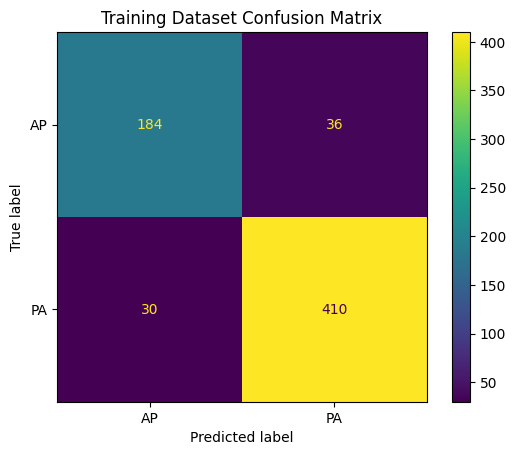

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 89.09%
Number of predictions:  220
Precision: 0.88, Recall: 0.96, F1 score: 0.92
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.91      0.76      0.83        76
           1       0.88      0.96      0.92       144

    accuracy                           0.89       220
   macro avg       0.90      0.86      0.87       220
weighted avg       0.89      0.89      0.89       220

Predicted lables:  [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1

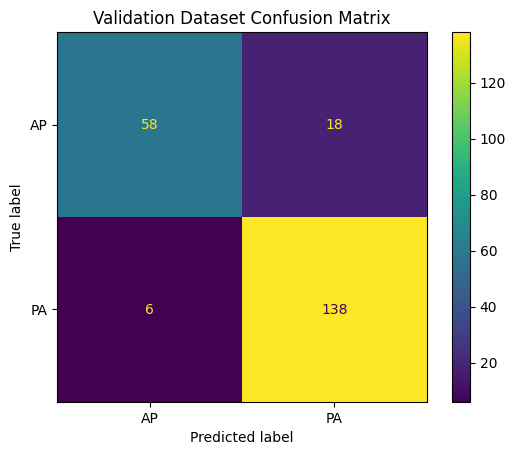

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

## 80 batch size
### train macro accuracy = 89%; val macro accuracy = 85%

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# model hyperparameters
h = {
    "num_epochs": 10,
    "batch_size": 80,
    "image_size": 100,
    "fc1_size": 512,
    "lr": 0.001
}

# Create the model and optimizer
model = nn.Sequential(
  nn.Conv2d(1, 15, 3, stride = 1, padding = 1),
  # (input channels, output channels, filter size, stride, padding)
  # padding = 1 is similar to "padding=same" in keras
  # input channels --> number image color channels [grayscale: 1; rgb: 3]
  # output channels --> number of filters/kernels --> meaning number of neurons
  nn.ReLU(),
  # conv2D activation
  nn.MaxPool2d(2, 2),
  # image output shape reduced by factor of 2:  ex. before --> 1x56x56, after --> 1x28x28

  nn.Conv2d(15, 8, 3, stride = 1, padding = 1),
  # input channels should match previous convolutional layer
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  # flaaten image for fully connected layer
  nn.Flatten(),

  nn.Linear(8 * ((h["image_size"] // 2) //2) * ((h["image_size"] // 2) //2), 512),
  # fully connected layer
  # (input_features, output_features)
  # input_features = number of features/filters from last conv2D layer * ( image channels * new height * new width)
  # ---> where new height & width = (conv height / (number of max pooling * max pooling factor))  = output after last max pool
  # output_features = number of neurons

  nn.ReLU(),
  # fully connected activation

  nn.Linear(512, 2),

  nn.Sigmoid()
  # output layer, classifies everything.
  # (input_features, output_features)
  # input_features = last layer's output --> meaning number of neurons
  # output_features
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(h['image_size'], h['batch_size'])

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

0.weight cuda:0
0.bias cuda:0
3.weight cuda:0
3.bias cuda:0
7.weight cuda:0
7.bias cuda:0
9.weight cuda:0
9.bias cuda:0

Training Dataset
Total batches: 9
Total samples: 660
Images per batch: 80

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  220
Number of 1s (PA):  440
Validation
Number of 0s (AP):  76
Number of 1s (PA):  144


Epoch [1/10], Train Loss: 0.6483, Train Acc: 0.6667, Val Loss: 0.6290, Val Acc: 0.6545, Time: 9.12 sec
Epoch [2/10], Train Loss: 0.6193, Train Acc: 0.6667, Val Loss: 0.6027, Val Acc: 0.6545, Time: 9.16 sec
Epoch [3/10], Train Loss: 0.5713, Train Acc: 0.7091, Val Loss: 0.5756, Val Acc: 0.6727, Time: 8.40 sec
Epoch [4/10], Train Loss: 0.5210, Train Acc: 0.7742, Val Loss: 0.5286, Val Acc: 0.7455, Time: 9.04 sec
Epoch [5/10], Train Loss: 0.4844, Train Acc: 0.8121, Val Loss: 0.4781, Val Acc: 0.8591, Time: 9.00 sec
Epoch [6/10], Train Loss: 0.4762, Train Acc: 0.8333, Val Loss: 0.4403, Val Acc: 0.8818, Time: 8.18 sec
Epoch [7/10], Train Loss: 0.5027, Train Acc: 0.7939, Val Loss: 0.4645, Val Acc: 0.8364, Time: 9.70 sec
Epoch [8/10], Train Loss: 0.4534, Train Acc: 0.8455, Val Loss: 0.4508, Val Acc: 0.8409, Time: 19.49 sec
Epoch [9/10], Train Loss: 0.4367, Train Acc: 0.8742, Val Loss: 0.4557, Val Acc: 0.8409, Time: 12.48 sec
Epoch [10/10], Train Loss: 0.4320, Train Acc: 0.8742, Val Loss: 0.4320,

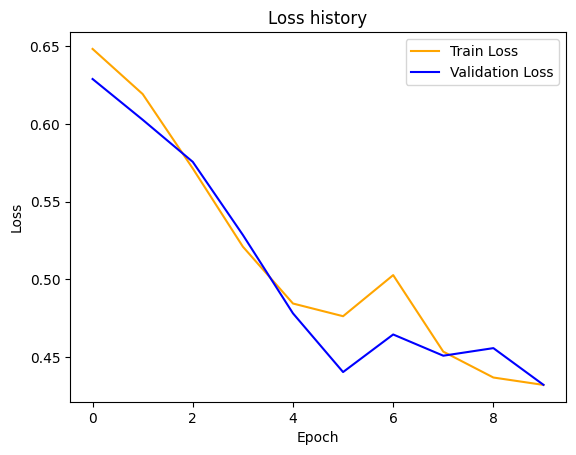

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Accuracy on the Training set: 90.91%
Number of predictions:  660
Precision: 0.90, Recall: 0.97, F1 score: 0.93
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       220
           1       0.90      0.97      0.93       440

    accuracy                           0.91       660
   macro avg       0.92      0.88      0.89       660
weighted avg       0.91      0.91      0.91       660

Predicted lables:  [1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,

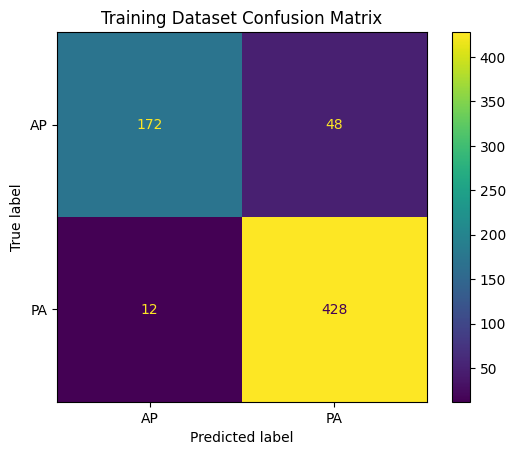

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 87.73%
Number of predictions:  220
Precision: 0.85, Recall: 0.98, F1 score: 0.91
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.95      0.68      0.79        76
           1       0.85      0.98      0.91       144

    accuracy                           0.88       220
   macro avg       0.90      0.83      0.85       220
weighted avg       0.89      0.88      0.87       220

Predicted lables:  [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1

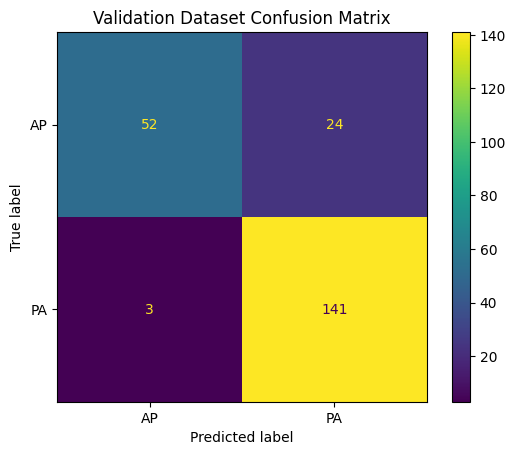

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

## 60 batch size
### train macro accuracy = 86%; val macro accuracy = 81%


In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch import nn

# model hyperparameters
h = {
    "num_epochs": 10,
    "batch_size": 60,
    "image_size": 100,
    "fc1_size": 512,
    "lr": 0.001
}

# Create the model and optimizer
model = nn.Sequential(
  nn.Conv2d(1, 15, 3, stride = 1, padding = 1),
  # (input channels, output channels, filter size, stride, padding)
  # padding = 1 is similar to "padding=same" in keras
  # input channels --> number image color channels [grayscale: 1; rgb: 3]
  # output channels --> number of filters/kernels --> meaning number of neurons
  nn.ReLU(),
  # conv2D activation
  nn.MaxPool2d(2, 2),
  # image output shape reduced by factor of 2:  ex. before --> 1x56x56, after --> 1x28x28

  nn.Conv2d(15, 8, 3, stride = 1, padding = 1),
  # input channels should match previous convolutional layer
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  # flaaten image for fully connected layer
  nn.Flatten(),

  nn.Linear(8 * ((h["image_size"] // 2) //2) * ((h["image_size"] // 2) //2), 512),
  # fully connected layer
  # (input_features, output_features)
  # input_features = number of features/filters from last conv2D layer * ( image channels * new height * new width)
  # ---> where new height & width = (conv height / (number of max pooling * max pooling factor))  = output after last max pool
  # output_features = number of neurons

  nn.ReLU(),
  # fully connected activation

  nn.Linear(512, 2),

  nn.Sigmoid()
  # output layer, classifies everything.
  # (input_features, output_features)
  # input_features = last layer's output --> meaning number of neurons
  # output_features
)

# MAKING SURE MODEL IS USING GPU
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

#model.reset_classifier(20) # not sure if this is truly necessary
model = model.to(device)

for name, param in model.named_parameters():
   print(name, param.device)

print("")
# load datasets
train_loader, train_dataset, val_loader, valid_dataset, test_loader, test_dataset = resize_batches(h['image_size'], h['batch_size'])

# optimizer & criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00001
criterion = nn.CrossEntropyLoss()

Device: cuda

0.weight cuda:0
0.bias cuda:0
3.weight cuda:0
3.bias cuda:0
7.weight cuda:0
7.bias cuda:0
9.weight cuda:0
9.bias cuda:0

Training Dataset
Total batches: 11
Total samples: 660
Images per batch: 60

Validation Dataset
Total samples: 220

Testing Dataset
Total samples: 220



In [ ]:
# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Training")
for label in train_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

# checking dataset label classifications
count_0s = 0
count_1s = 0
print("Validation")
for label in valid_dataset.targets:
  if label == 0:
    count_0s = count_0s +1
  else:
    count_1s = count_1s +1

print("Number of 0s (AP): ", count_0s)
print("Number of 1s (PA): ", count_1s)

Training
Number of 0s (AP):  220
Number of 1s (PA):  440
Validation
Number of 0s (AP):  76
Number of 1s (PA):  144


Epoch [1/10], Train Loss: 0.6569, Train Acc: 0.6212, Val Loss: 0.6552, Val Acc: 0.6545, Time: 9.16 sec
Epoch [2/10], Train Loss: 0.6318, Train Acc: 0.6667, Val Loss: 0.6207, Val Acc: 0.6545, Time: 10.85 sec
Epoch [3/10], Train Loss: 0.6107, Train Acc: 0.6682, Val Loss: 0.5995, Val Acc: 0.7045, Time: 15.18 sec
Epoch [4/10], Train Loss: 0.5732, Train Acc: 0.7121, Val Loss: 0.5278, Val Acc: 0.8273, Time: 9.73 sec
Epoch [5/10], Train Loss: 0.5168, Train Acc: 0.8045, Val Loss: 0.5031, Val Acc: 0.7864, Time: 9.35 sec
Epoch [6/10], Train Loss: 0.4967, Train Acc: 0.8121, Val Loss: 0.4533, Val Acc: 0.8682, Time: 8.71 sec
Epoch [7/10], Train Loss: 0.4769, Train Acc: 0.8303, Val Loss: 0.4797, Val Acc: 0.8364, Time: 9.11 sec
Epoch [8/10], Train Loss: 0.4557, Train Acc: 0.8545, Val Loss: 0.4433, Val Acc: 0.8591, Time: 10.00 sec
Epoch [9/10], Train Loss: 0.4340, Train Acc: 0.8833, Val Loss: 0.4137, Val Acc: 0.8864, Time: 8.54 sec
Epoch [10/10], Train Loss: 0.4226, Train Acc: 0.8833, Val Loss: 0.4574

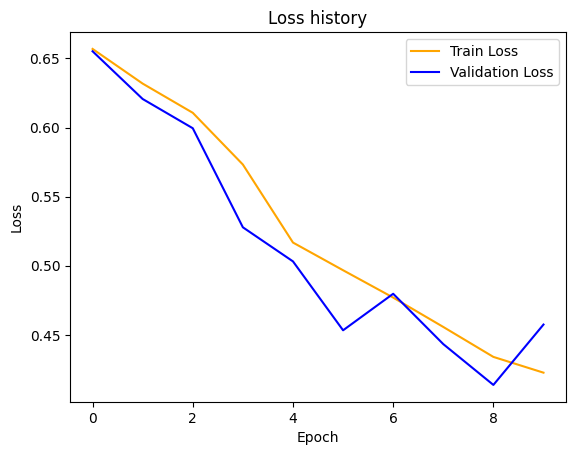

In [ ]:
epochs = 10
training(model, train_loader, val_loader, optimizer, criterion, epochs, device)
# updated training function to show graph next time

Accuracy on the Training set: 88.18%
Number of predictions:  660
Precision: 0.86, Recall: 0.98, F1 score: 0.92
Classification Report for  Training  Dataset
              precision    recall  f1-score   support

           0       0.94      0.69      0.79       220
           1       0.86      0.98      0.92       440

    accuracy                           0.88       660
   macro avg       0.90      0.83      0.86       660
weighted avg       0.89      0.88      0.88       660

Predicted lables:  [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,

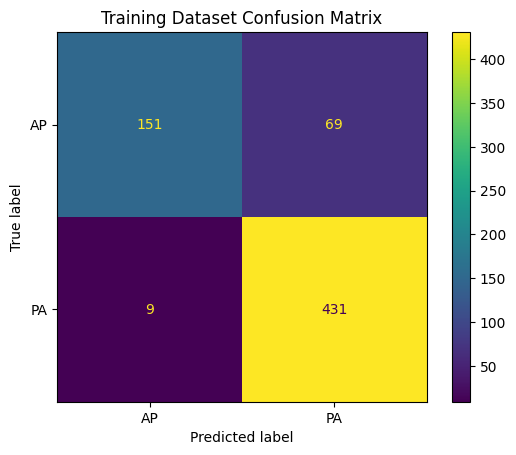

In [ ]:
string = "Training"
get_performance(model, train_loader, train_dataset, string, device) # uses gpu

Accuracy on the Validation set: 84.55%
Number of predictions:  220
Precision: 0.82, Recall: 0.99, F1 score: 0.89
Classification Report for  Validation  Dataset
              precision    recall  f1-score   support

           0       0.96      0.58      0.72        76
           1       0.82      0.99      0.89       144

    accuracy                           0.85       220
   macro avg       0.89      0.78      0.81       220
weighted avg       0.86      0.85      0.83       220

Predicted lables:  [1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1

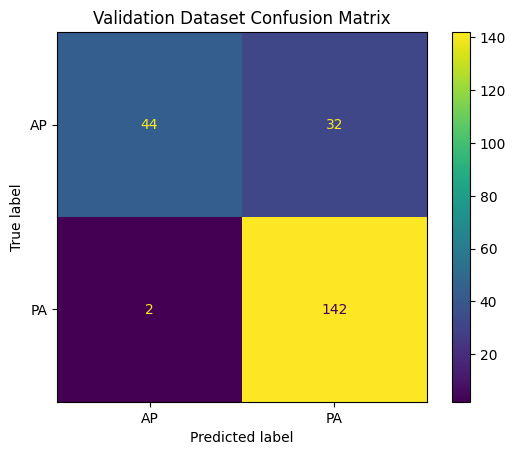

In [ ]:
string = "Validation"
get_performance(model, val_loader, valid_dataset, string, device) # uses gpu

# <font color= 'blue'> Classifying Test Dataset!
Predictions for test set performed around 6% worse than predictions for validation and training sets -- some overfitting present in model. Precision and Recall scores were very high.

82% Macro Average Accuracy

0.89 Precision

0.90 Recall

0.90 F1 Score


Accuracy on the Test set: 85.45%
Number of predictions:  220
Precision: 0.89, Recall: 0.90, F1 score: 0.90
Classification Report for  Test  Dataset
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        65
           1       0.89      0.90      0.90       155

    accuracy                           0.85       220
   macro avg       0.83      0.82      0.82       220
weighted avg       0.85      0.85      0.85       220

Predicted lables:  [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1

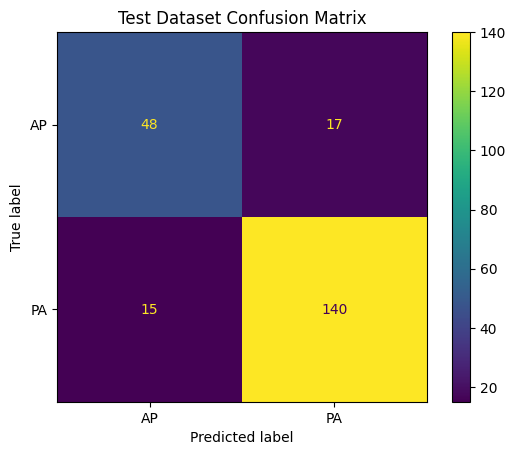

In [ ]:
string = "Test"
get_performance(model, test_loader, test_dataset, string, device) # uses gpu

# <font color= 'blue'> Evaluation of Models & Discussion

In this dataset, the number of X-Ray images labeled as a PA view (posterior-anterior)
view was twice the number of X-Ray images labeled as a AP view (anterior-posterior). Because of the class imbalance, the macro-average accuracy was used to evaluation the models. The importance of precision and recall was valued the same, although recall was more important to look at since it includes a calculation of false negatives (0 = AP, 1 = PA). The recall metric magnified whether the model was predicting the images as AP correctly.

Before 2 convolutional layers were added, the model was unable to learn the dataset and was stuck at a average value. However, after using 2 convolutional layers, macro accuracy improved a lot and the model started to learn the dataset much better. This performance was improved with the following experiments, ending with a test classification (macro) accuracy of 82%. The recall and precision score was also at a high of 0.89 and 0.90, respectively.

# <font color= 'blue'> Future Improvements

Although cross validation was not performed for this project, estimates for overfitting may have been better if it had been implemented due to the small size of the dataset. Additionally, since this was a subset of a much larger dataset, the entire dataset could be used for future improvements and more robust training. Some other future improvements could be to standardize the data, use class weights in the training the network, or preprocress the input images with dimensional reduction methods.

It was expected that the model would achieve a high accuracy of 80% - 90% since the classifications were based which view the X-Rays were taken from. This project required 2 convolutional layers before models showed any improvement in results, despite being a problem not as challenging or complicated as classifying diseases. Although modifiying the goal caused the problem to become a simplier classification, the results were still very interesting and required a lot of hyperparameter tuning.